<a href="https://colab.research.google.com/github/raregem-AI/Machine-Learning-Projects/blob/main/DSN_BootCamp20ication_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

hackathon_qualification_path = kagglehub.competition_download('hackathon-qualification')
taeefnajib_used_car_price_prediction_dataset_path = kagglehub.dataset_download('taeefnajib/used-car-price-prediction-dataset')

print('Data source import complete.')


In [ ]:
## Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns

import numpy as np
import pandas as pd
import datetime
import shap
import random
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge

from category_encoders import TargetEncoder

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.svm import LinearSVR, SVR
#from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
seed = 42
VER=7
n_folds = 5
n_bags = 3
TESTRUN = False

In [ ]:
#Load the data
train = pd.read_csv("/kaggle/input/hackathon-qualification/archive/train.csv")
test = pd.read_csv("/kaggle/input/hackathon-qualification/archive/test.csv")
orig = pd.read_csv("/kaggle/input/used-car-price-prediction-dataset/used_cars.csv")
ss = pd.read_csv("/kaggle/input/hackathon-qualification/archive/sample_submission.csv")


df_train=pd.read_csv("/kaggle/input/hackathon-qualification/archive/train.csv", index_col=0)
df_original = pd.read_csv("/kaggle/input/used-car-price-prediction-dataset/used_cars.csv")
df_test=pd.read_csv("/kaggle/input/hackathon-qualification/archive/test.csv", index_col=0)
sample_sub=pd.read_csv("/kaggle/input/hackathon-qualification/archive/sample_submission.csv")

#clean original columns
df_original[['milage', 'price']] = df_original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

#prepare dataframes for the oof and test predictions:
oof_df = pd.read_csv("/kaggle/input/hackathon-qualification/archive/train.csv")[["id"]]
test_df = pd.read_csv("/kaggle/input/hackathon-qualification/archive/test.csv")[["id"]]

In [ ]:
if TESTRUN:
    df_train = df_train.sample(frac=0.2, random_state=seed)
    df_original = df_original.sample(frac=0.2, random_state=seed)
    oof_df = oof_df.sample(frac = 0.2, random_state = seed)

In [ ]:
#Checking the data size
print("Number of entries in training data:",len(df_train))
print("Number of entries in test data:",len(df_test))
print("Number of columns in training data:",len(df_train.columns))
print("Number of columns in test data:",len(df_test.columns))
print("Columns in training data:", df_train.columns)

Number of entries in training data: 188533
Number of entries in test data: 125690
Number of columns in training data: 12
Number of columns in test data: 11
Columns in training data: Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')


In [ ]:
# first five rrole
df_train.head()

brand              model  model_year  milage      fuel_type  \
id                                                                        
0            MINI      Cooper S Base        2007  213000       Gasoline   
1         Lincoln              LS V8        2002  143250       Gasoline   
2       Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3         Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                               engine  \
id                                                      
0        172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1        252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2   320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3        420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4        208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                      transmission ext_col int_col  \
id                                                   
0                              A/T  Yellow    Gray   
1                              A/T  Silver   Beige   
2                              A/T    Blue    Gray   
3   Transmission w/Dual Shift Mode   Black   Black   
4                      7-Speed A/T   Black   Beige   

                                  accident clean_title  price  
id                                                             
0                            None reported         Yes   4200  
1   At least 1 accident or damage reported         Yes   4999  
2                            None reported         Yes  13900  
3                            None reported         Yes  45000  
4                            None reported         Yes  97500

In [ ]:
#check for data types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 18.7+ MB


In [ ]:
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
            'int_col', 'accident']
num_cols = ['model_year', 'milage']

In [ ]:
#check for duplicate
feature_cols = df_test.columns.to_list()
print("Number of duplicates in train data:", len(df_train[df_train[feature_cols].duplicated()]), "\n")
print("Number of duplicates in test data:", len(df_test[df_test.duplicated()]), "\n")

Number of duplicates in train data: 0 

Number of duplicates in test data: 0 



## Exploratory Data Analysis

In [ ]:
feat_stat = {}
for feature in df_train.columns:
    feat_stat[feature] = np.round(df_train[
        feature].value_counts().describe())[['count','mean', 'min', 'max']].astype(int)
feat_stat_df = pd.DataFrame(feat_stat)
feat_stat_df.T.sort_values(by=['count'])

count    mean     min     max
clean_title       1  167114  167114  167114
accident          2   93040   41567  144514
fuel_type         7   26207      15  165940
model_year       34    5545      12   18198
transmission     52    3626       6   49904
brand            57    3308       3   23088
int_col         156    1209       4  107674
ext_col         319     591       2   48658
engine         1117     169       1    3462
price          1569     120      19    1920
model          1897      99       1    2945
milage         6651      28       1    1319

In [ ]:
# #Cardinalty of target
# print(df_train['price'].value_counts().sort_index().to_string())
print(len(df_train['price'].value_counts().to_string()))

25109


In [ ]:
print(len(df_train['price'].value_counts().to_string()))

25109


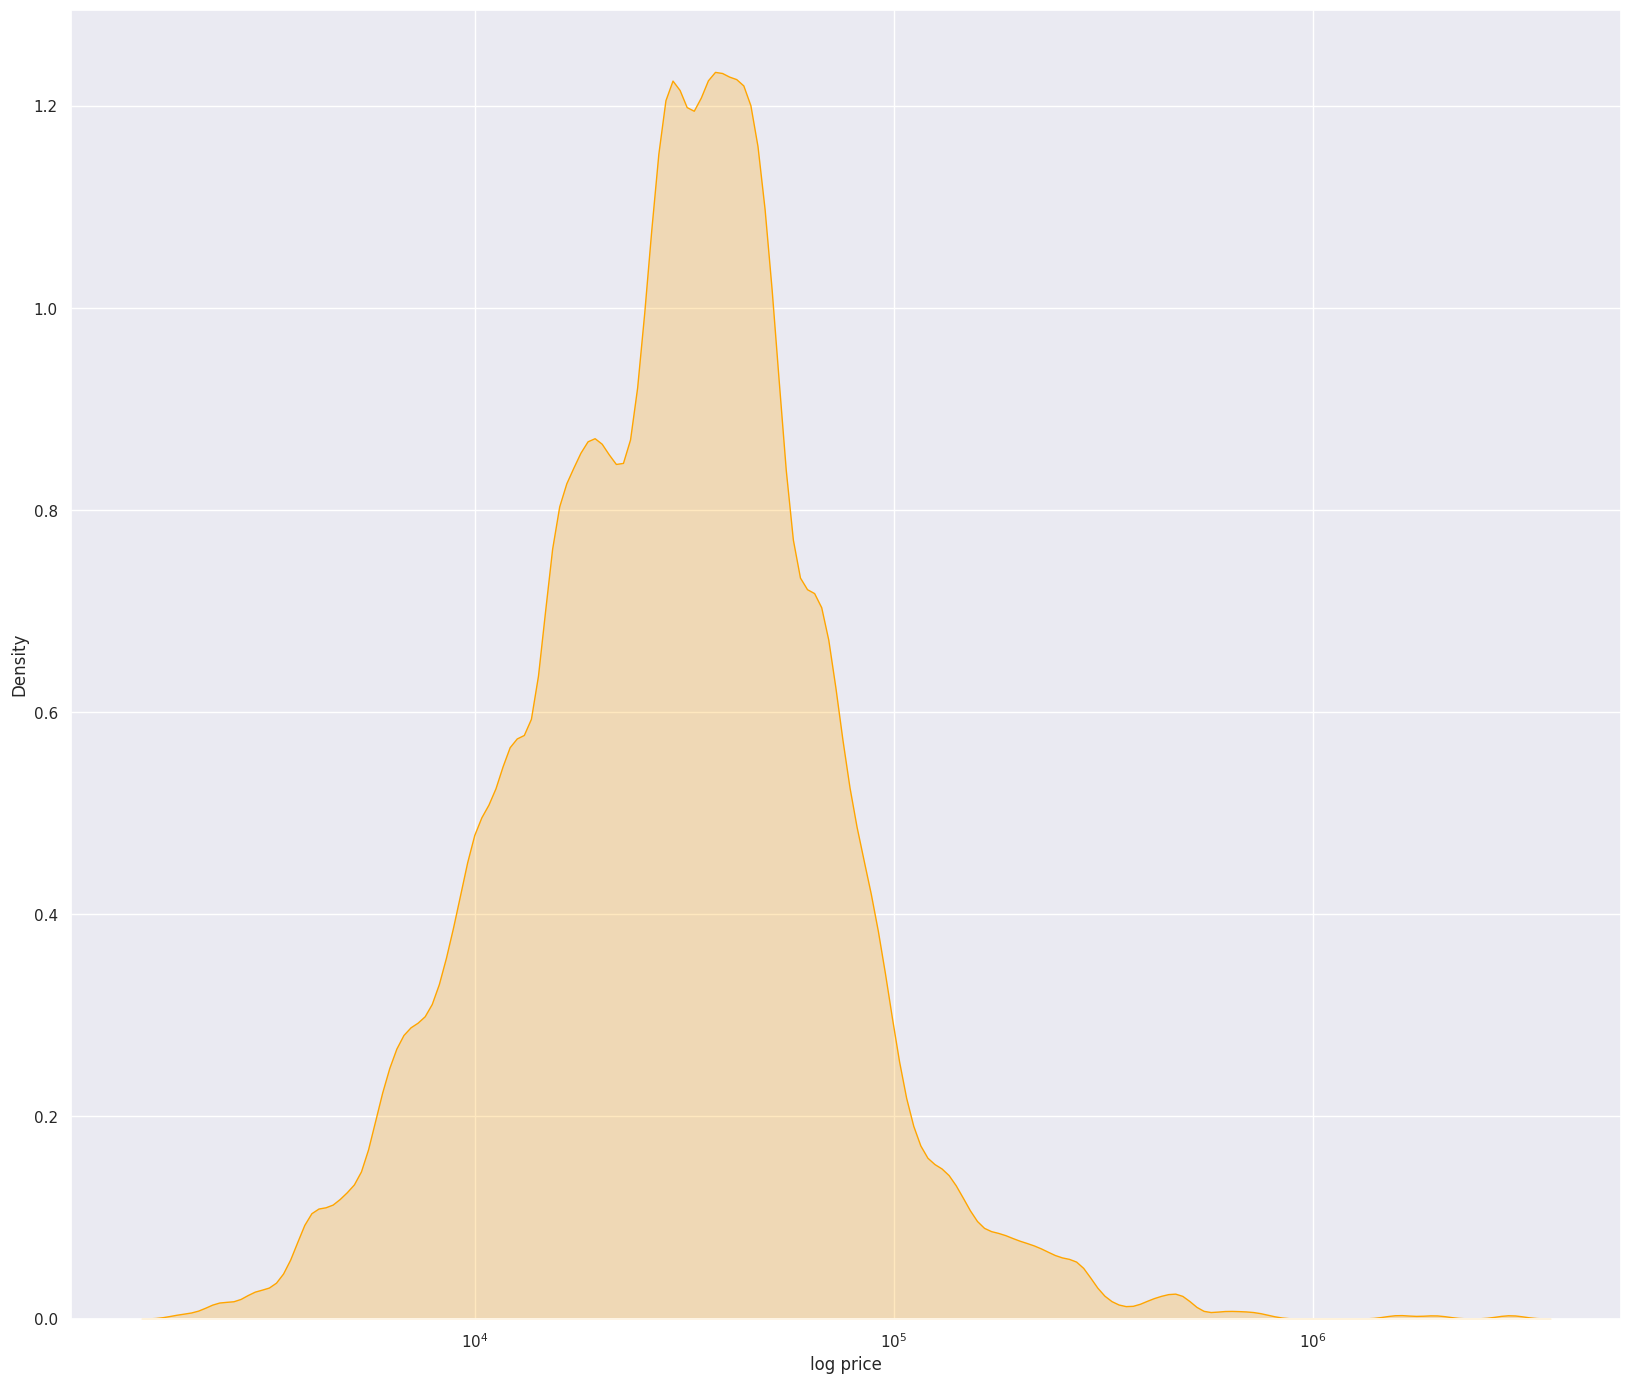

In [ ]:
ax = sns.kdeplot(df_train['price'], color='orange', fill=True, log_scale=True)
ax.set(xlabel='log price');

### Categorical variables

In [ ]:
def display_categories(df, feature, sort_feature='median price'):
    """
    displays the full list of categories of a categorical feature together with their
    properties count and mean and median price for each category
    """
    mean_price_per_category = np.round(df_train.groupby(feature)[
        'price'].mean()).reset_index().rename(columns={'price': 'mean price'})
    median_price_per_category = df_train.groupby(feature)[
        'price'].median().reset_index().rename(columns={'price': 'median price'})
    category_counts = pd.DataFrame(df_train[feature].value_counts())
    merger = pd.merge(mean_price_per_category, category_counts, on=feature)
    merger = pd.merge(median_price_per_category,merger, on = feature).sort_values(by=sort_feature)
    print(merger.to_string(index = False))
    return merger

In [ ]:
for c in cat_cols + ['model_year','milage']:
    # compare test and train cat values
    A=df_train[c].astype('str').unique()
    B=df_test[c].astype('str').unique()
    C = np.setdiff1d(B,A)
    print(f"{c}: Test has categories {C} which are not in train.")
    if len(C)>0:
        print(f" => {len(df_test.loc[df_test[c].astype(str).isin(C)])} rows" )

    # RELABEL UNSEEN TEST VALUES AS ZERO
    #test.loc[test[c].isin(C),c] = 0

brand: Test has categories [] which are not in train.
model: Test has categories ['allroad 2.7T'] which are not in train.
 => 1 rows
fuel_type: Test has categories [] which are not in train.
engine: Test has categories ['177.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas'] which are not in train.
 => 4 rows
transmission: Test has categories [] which are not in train.
ext_col: Test has categories [] which are not in train.
int_col: Test has categories [] which are not in train.
accident: Test has categories [] which are not in train.
model_year: Test has categories ['1982' '1988'] which are not in train.
 => 2 rows
milage: Test has categories ['100633' '100678' '10073' ... '99876' '9988' '99981'] which are not in train.
 => 1981 rows


In [ ]:
#accident feature
merger = display_categories(df_train, 'accident')

                              accident  median price  mean price  count
At least 1 accident or damage reported       18000.0     25334.0  41567
                         None reported       35000.0     49025.0 144514


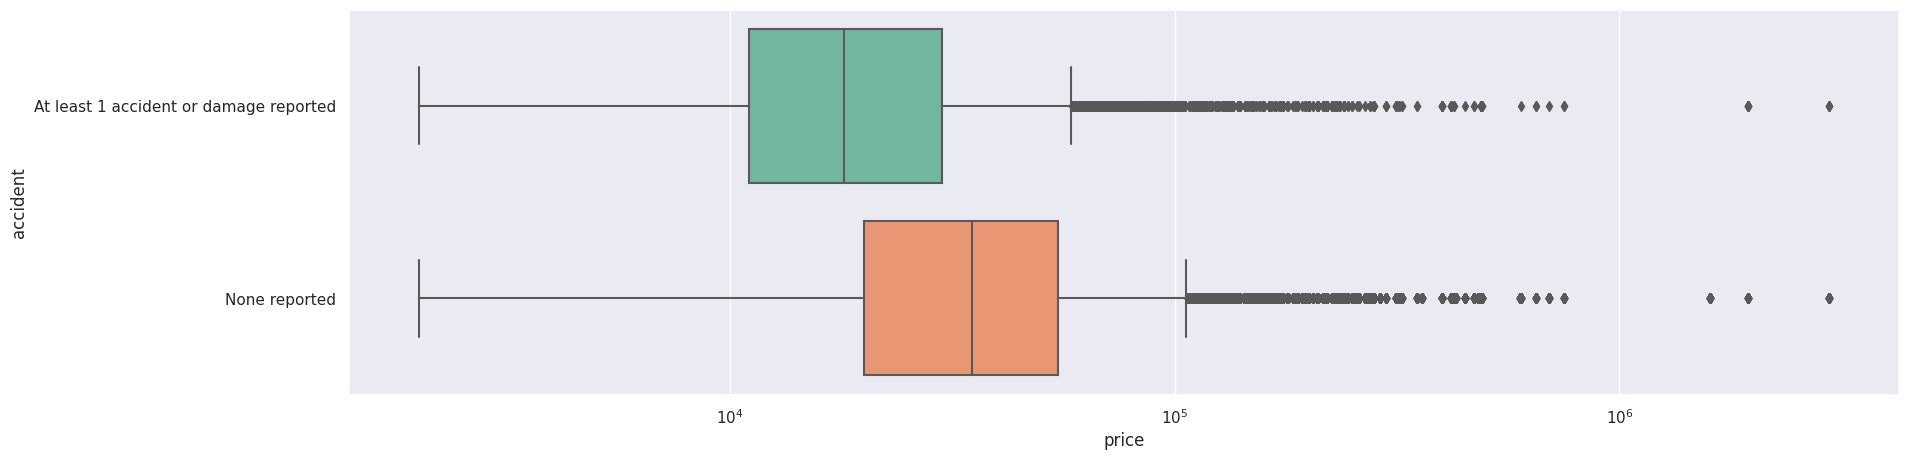

In [ ]:
sns.set(rc={'figure.figsize': (20, 5)})
mean_price_order = df_train.groupby('accident')['price'].median().sort_values().index
sns.boxplot(y=df_train['accident'], x=df_train['price'], palette='Set2',
           order=mean_price_order)
plt.xscale('log')

In [ ]:
## fuel type
merger = display_categories(df_train, 'fuel_type')

     fuel_type  median price  mean price  count
 not supported       14000.0     20693.0     15
             –       16250.0     36414.0    781
 E85 Flex Fuel       19900.0     26730.0   5406
      Gasoline       29999.0     43360.0 165940
        Diesel       38500.0     48770.0   3955
Plug-In Hybrid       38880.0     44151.0    521
        Hybrid       44900.0     55473.0   6832


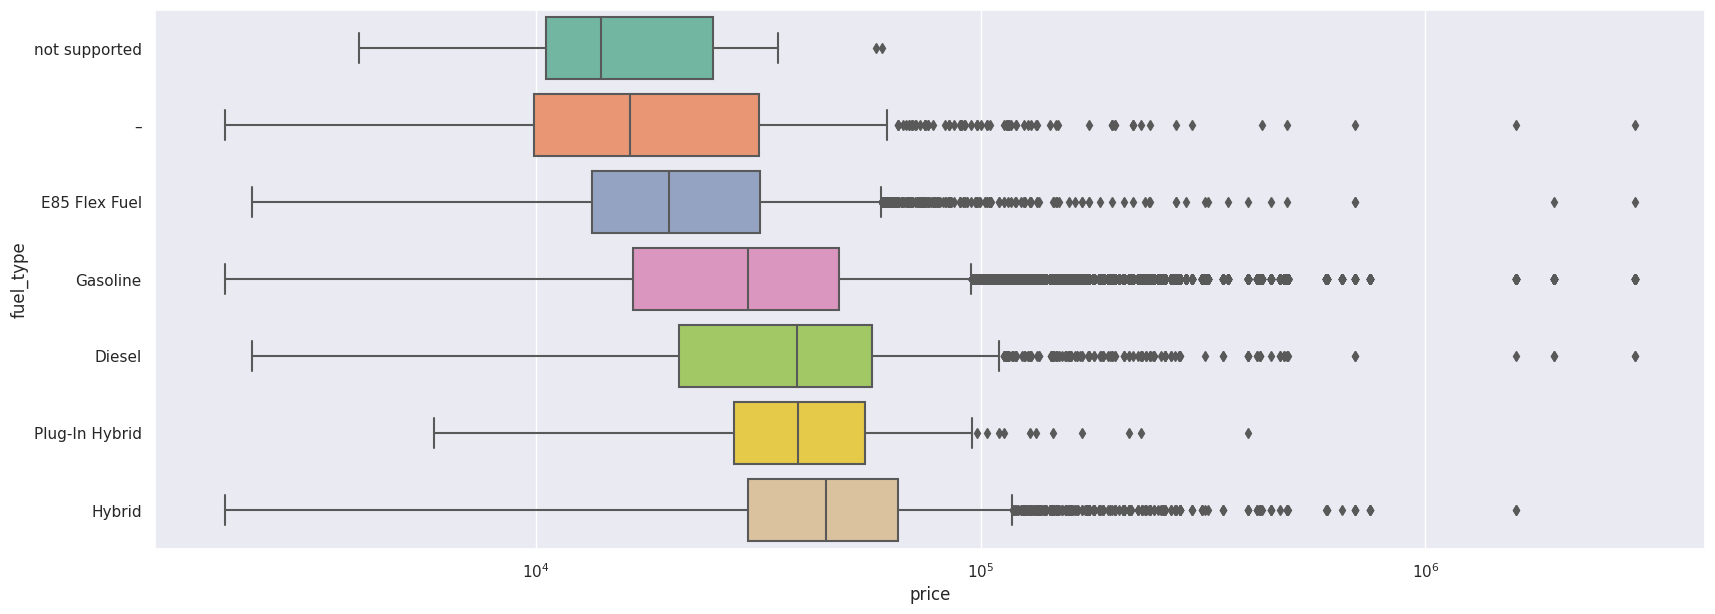

In [ ]:
sns.set(rc={'figure.figsize': (20, 7)})
mean_price_order = df_train.groupby('fuel_type')['price'].median().sort_values().index
sns.boxplot(y=df_train['fuel_type'], x=df_train['price'], palette='Set2',
           order=mean_price_order)
plt.xscale('log')

In [ ]:
#Transmission
display_categories(df_train, 'transmission')

                                      transmission  median price  mean price  count
                                       4-Speed A/T       10000.0     16940.0   2546
                                       5-Speed M/T       11495.0     16330.0   2409
                                       5-Speed A/T       12900.0     21195.0   3217
                                               M/T       15999.0     27915.0   1179
                                       6-Speed A/T       19978.5     25865.0  18044
                                               A/T       20500.0     31712.0  49904
                                  CVT Transmission       20999.0     25587.0   1990
                                       6-Speed M/T       21999.0     33267.0  11998
                     Transmission Overdrive Switch       23750.0     27755.0    156
                                 4-Speed Automatic       27461.5     89443.0     48
                                             CVT-F       27785.0     30937.0

transmission  median price  \
8                                         4-Speed A/T       10000.0   
12                                        5-Speed M/T       11495.0   
10                                        5-Speed A/T       12900.0   
44                                                M/T       15999.0   
16                                        6-Speed A/T       19978.5   
38                                                A/T       20500.0   
41                                   CVT Transmission       20999.0   
20                                        6-Speed M/T       21999.0   
48                      Transmission Overdrive Switch       23750.0   
9                                   4-Speed Automatic       27461.5   
42                                              CVT-F       27785.0   
19  6-Speed Electronically Controlled Automatic wi...       28748.0   
18                  6-Speed Automatic with Auto-Shift       28906.0   
17                                  6-Speed Automatic       29998.0   
40                                      Automatic CVT       31853.0   
11                                  5-Speed Automatic       31853.0   
23                                        7-Speed A/T       32175.0   
13                                      6 Speed At/Mt       33498.5   
43                                                  F       33998.0   
49                     Transmission w/Dual Shift Mode       35999.0   
5                                                   2       36598.0   
14                                         6 Speed Mt       36598.0   
30                                         8-SPEED AT       39599.0   
15                                            6-Speed       39985.0   
36                                  9-Speed Automatic       40995.0   
31                                        8-Speed A/T       41000.0   
32                                  8-Speed Automatic       41999.0   
24                                  7-Speed Automatic       42549.0   
50                                           Variable       42798.0   
45                                             Manual       43775.0   
35                                        9-Speed A/T       44900.0   
39                                          Automatic       44998.0   
3                                  10-Speed Automatic       45277.0   
46                     SCHEDULED FOR OR IN PRODUCTION       45321.5   
1                                   1-Speed Automatic       46552.0   
0                                         1-Speed A/T       48000.0   
2                                        10-Speed A/T       48990.0   
21                                     6-Speed Manual       52999.0   
6                                         2-Speed A/T       54500.0   
27                                        7-Speed M/T       59200.0   
26                              7-Speed DCT Automatic       61452.5   
4                   10-Speed Automatic with Overdrive       65981.0   
25                  7-Speed Automatic with Auto-Shift       67979.0   
7                                   2-Speed Automatic       69947.5   
47                            Single-Speed Fixed Gear       77474.0   
37                  9-Speed Automatic with Auto-Shift       78500.0   
34                                     8-Speed Manual       85317.0   
51                                                  –       94500.0   
33                  8-Speed Automatic with Auto-Shift       99950.0   
28                                     7-Speed Manual      116911.0   
22                                            7-Speed      132900.0   
29                                        8-SPEED A/T      162500.0   

    mean price  count  
8      16940.0   2546  
12     16330.0   2409  
10     21195.0   3217  
44     27915.0   1179  
16     25865.0  18044  
38     31712.0  49904  
41     25587.0   1990  
20     33267.0  11998  
48     27755.0    156  
9      89443.0     48  
42     30937.

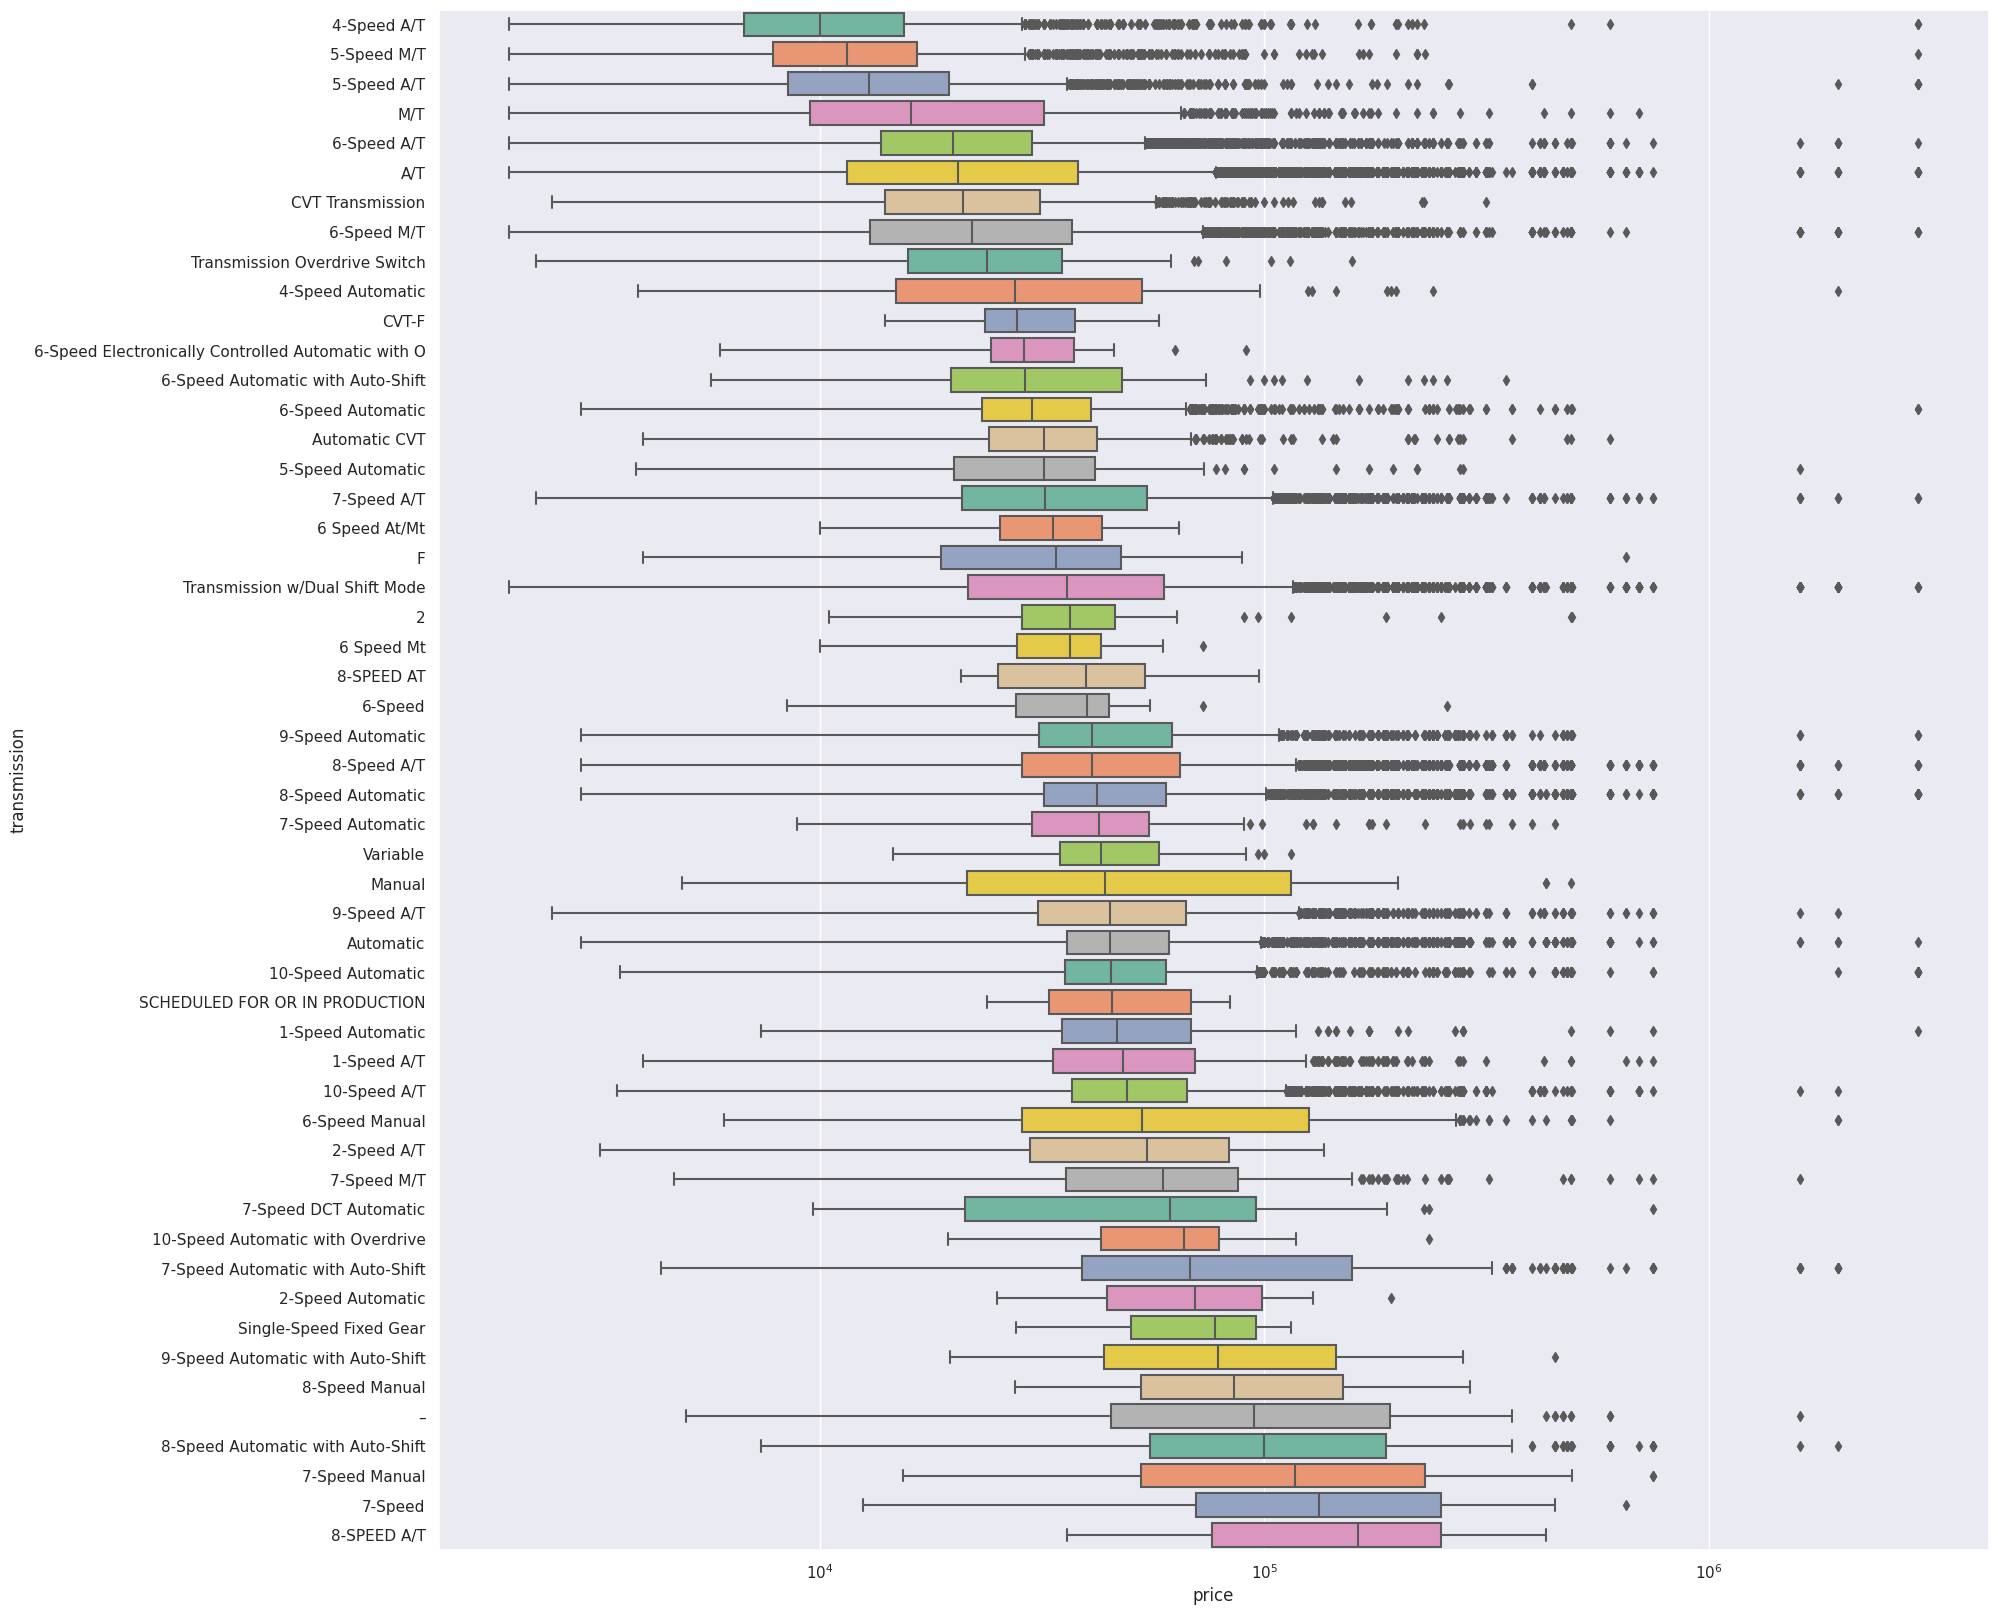

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
median_price_order = df_train.groupby('transmission')['price'].median().sort_values().index
sns.boxplot(y=df_train['transmission'], x=df_train['price'], palette='Set2',
           order=median_price_order)
plt.xscale('log')

In [ ]:
#brand
display_categories(df_train, 'brand')

        brand  median price  mean price  count
     Plymouth        9495.0     28095.0      7
        smart        9995.0     34664.0      3
   Mitsubishi       10300.0     18912.0    551
       Hummer       10900.0     15356.0    520
      Pontiac       10999.5     22528.0    538
       Saturn       12500.0     18204.0    148
         MINI       12992.5     17162.0   1064
        Scion       13675.0     14652.0    120
      Mercury       14900.0     26082.0     57
     Chrysler       14950.0     27011.0    727
        Honda       15900.0     22801.0   2101
       Subaru       17500.0     21521.0   2381
       Nissan       18000.0     29247.0   3930
        Dodge       18749.0     33278.0   3133
   Volkswagen       18900.0     26339.0   1765
      Hyundai       19000.0     25937.0   2045
       Suzuki       19000.0     30125.0      8
         FIAT       19249.5     31046.0     44
         Saab       20099.5     28594.0     22
        Acura       20653.5     28628.0   2282
        Mazda

brand  median price  mean price  count
40       Plymouth        9495.0     28095.0      7
56          smart        9995.0     34664.0      3
38     Mitsubishi       10300.0     18912.0    551
18         Hummer       10900.0     15356.0    520
42        Pontiac       10999.5     22528.0    538
48         Saturn       12500.0     18204.0    148
31           MINI       12992.5     17162.0   1064
49          Scion       13675.0     14652.0    120
37        Mercury       14900.0     26082.0     57
10       Chrysler       14950.0     27011.0    727
17          Honda       15900.0     22801.0   2101
50         Subaru       17500.0     21521.0   2381
39         Nissan       18000.0     29247.0   3930
11          Dodge       18749.0     33278.0   3133
54     Volkswagen       18900.0     26339.0   1765
19        Hyundai       19000.0     25937.0   2045
51         Suzuki       19000.0     30125.0      8
12           FIAT       19249.5     31046.0     44
47           Saab       20099.5     28594.0     22
0           Acura       20653.5     28628.0   2282
34          Mazda       20995.0     25333.0   2719
53         Toyota       22000.0     29148.0   8850
29          Lotus       22750.0     26436.0     52
28        Lincoln       23500.0     30713.0   2423
27          Lexus       25500.0     34801.0   8643
20       INFINITI       26000.0     33372.0   3276
7           Buick       26288.0     29618.0    940
55          Volvo       26500.0     30879.0    723
22           Jeep       29182.0     34117.0   6474
3            Audi       29900.0     41005.0  10887
23          Karma       30000.0     37384.0     17
24            Kia       30000.0     38072.0   2497
8        Cadillac       30500.0     45659.0   4674
4             BMW       31000.0     43660.0  17028
9       Chevrolet       32000.0     41837.0  16335
14           Ford       32000.0     40512.0  23088
15            GMC       32250.0     38936.0   3215
41       Polestar       33500.0     41755.0      7
36  Mercedes-Benz       36570.0     51244.0  19172
21         Jaguar       38000.0     48148.0   1319
26           Land       38998.0     53205.0   9525
1            Alfa       39900.0     51993.0    682
16        Genesis       39999.0     53556.0    969
44            RAM       40036.0     51291.0   4249
32       Maserati       43900.0     61460.0    939
43        Porsche       45900.0     70900.0  10612
52          Tesla       47500.0     56445.0   3738
33        Maybach       54999.0     53566.0      3
30          Lucid       56000.0     63310.0     69
2           Aston       67650.0    112365.0    238
5         Bentley       73600.0    129273.0   1155
13        Ferrari       75500.0    116751.0    359
46    Rolls-Royce       77500.0    135489.0    561
45         Rivian       78000.0     81089.0    590
35        McLaren       87500.0    123261.0    243
25    Lamborghini      102000.0    159176.0    809
6         Bugatti      220000.0    169600.0      7

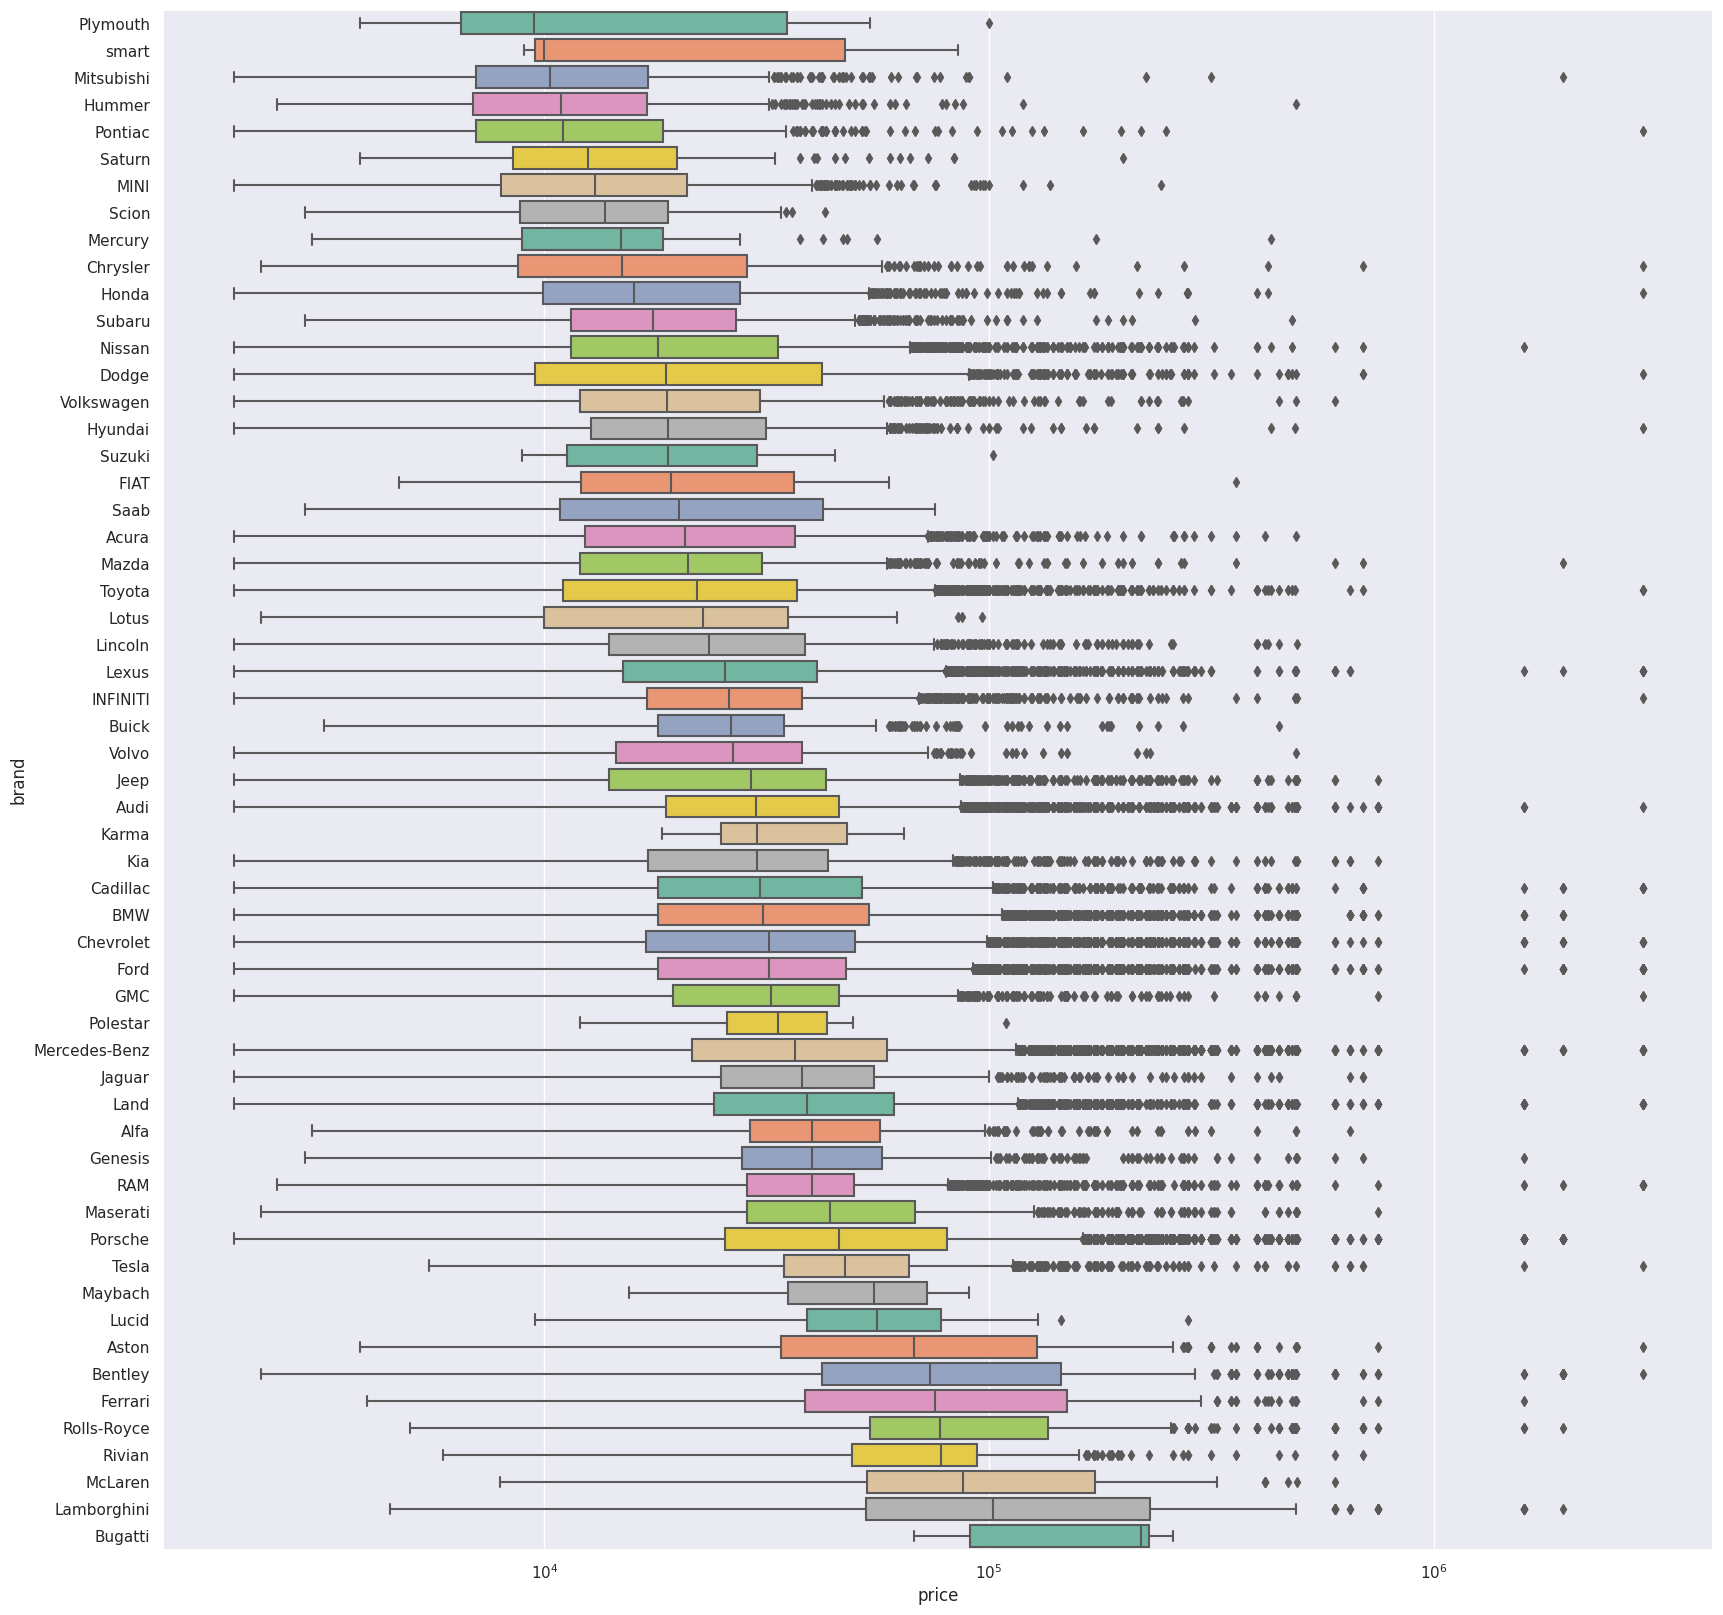

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
mean_price_order = df_train.groupby('brand')['price'].median().sort_values().index
ax = sns.boxplot(y=df_train['brand'], x=df_train['price'], palette='Set2',
           order=mean_price_order)
plt.xscale('log')

In [ ]:
#interior colour
merger = display_categories(df_train, 'int_col')

                   int_col  median price  mean price  count
                      Gray       17500.0     28182.0  21204
                      Gold       18688.0     40587.0    367
                     Beige       19780.0     29954.0  24495
                     Sport       21942.5     50869.0     10
                Light Gray       26548.5     26538.0      8
            Charcoal Black       27450.0     35367.0     73
        Black / Stone Grey       27518.0     43982.0     21
       Very Light Cashmere       28420.0     46590.0     10
             Medium Pewter       28590.0     29308.0     21
             White / Brown       28825.0     31696.0     79
                         –       28998.0     45753.0   4527
                Cappuccino       29535.5     47650.0     10
                 Graystone       29748.0     53590.0     23
                    Yellow       29999.0    106549.0     51
                     Amber       30744.0     63891.0     18
                       Ash       30825.0

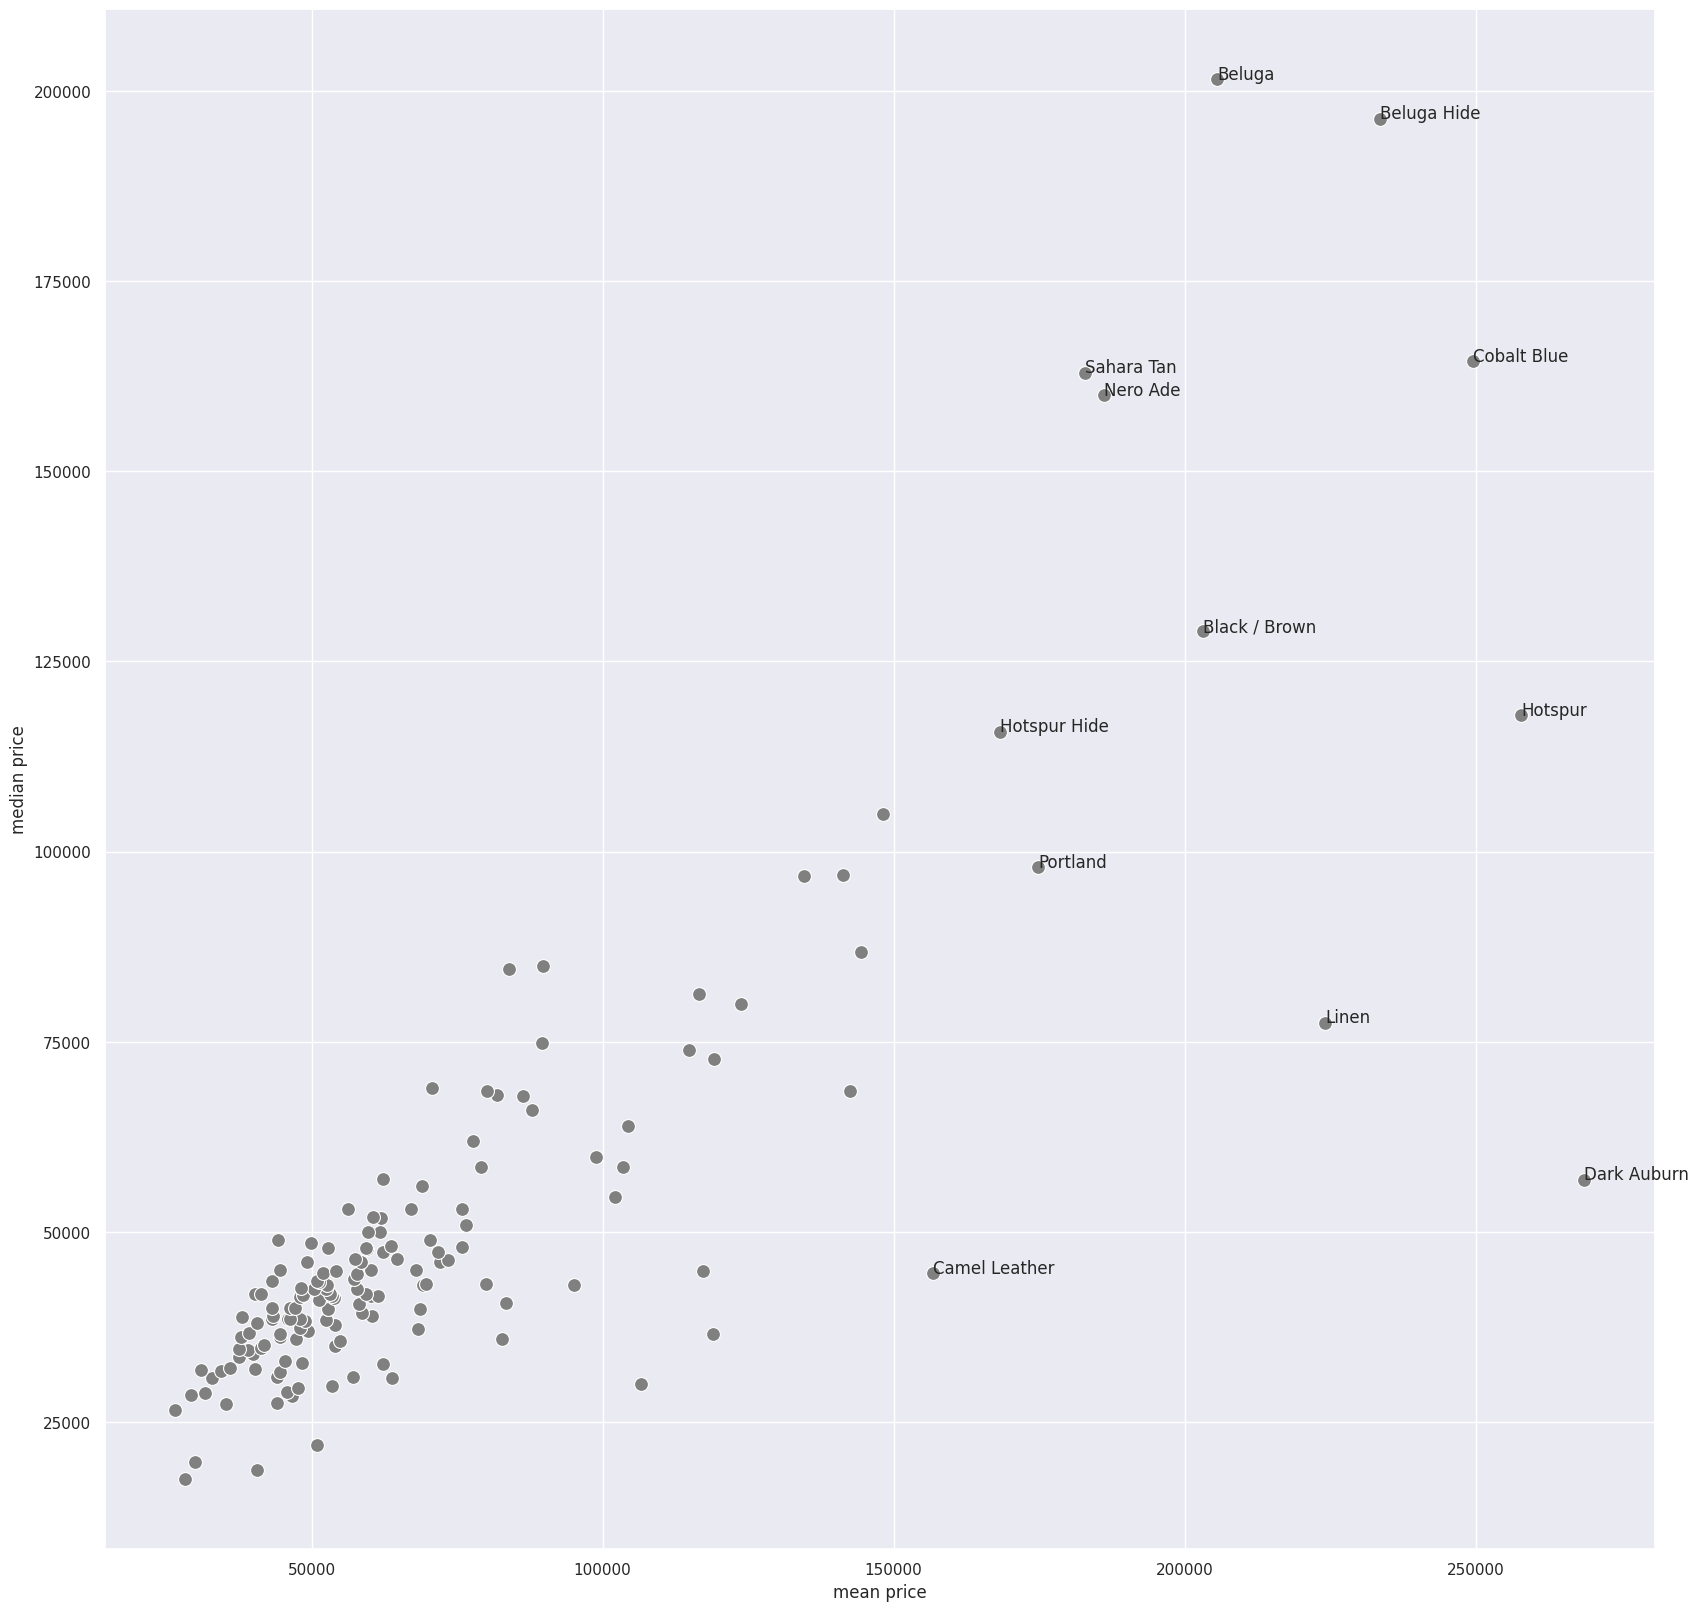

In [ ]:
sns.scatterplot(x=merger['mean price'], y=merger['median price'],
                color='grey', s = 100)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x'] > 150000:
            ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(merger['mean price'], merger['median price'], merger['int_col'], plt.gca())

plt.show()

In [ ]:
#exterior color
merger = display_categories(df_train, 'ext_col')

                                ext_col  median price  mean price  count
                                   Gold       12500.0     23091.0   1668
                                  Beige       13000.0     25639.0   1087
                                 Purple       18000.0     31672.0    354
                                 Silver       20000.0     31878.0  16995
                                  Brown       21500.0     33948.0   1162
                 Twilight Blue Metallic       23052.0     41275.0     30
                                    Red       24995.0     39978.0   9901
                           Frozen White       25073.5     25339.0      6
                         Dazzling White       25439.0     31408.0      8
                 Remington Red Metallic       25692.5     30918.0     26
         Snowflake White Pearl Metallic       25860.0     33636.0     48
                Radiant Red Metallic II       25884.0     30874.0     19
                       Blue Reflex Mica       25980

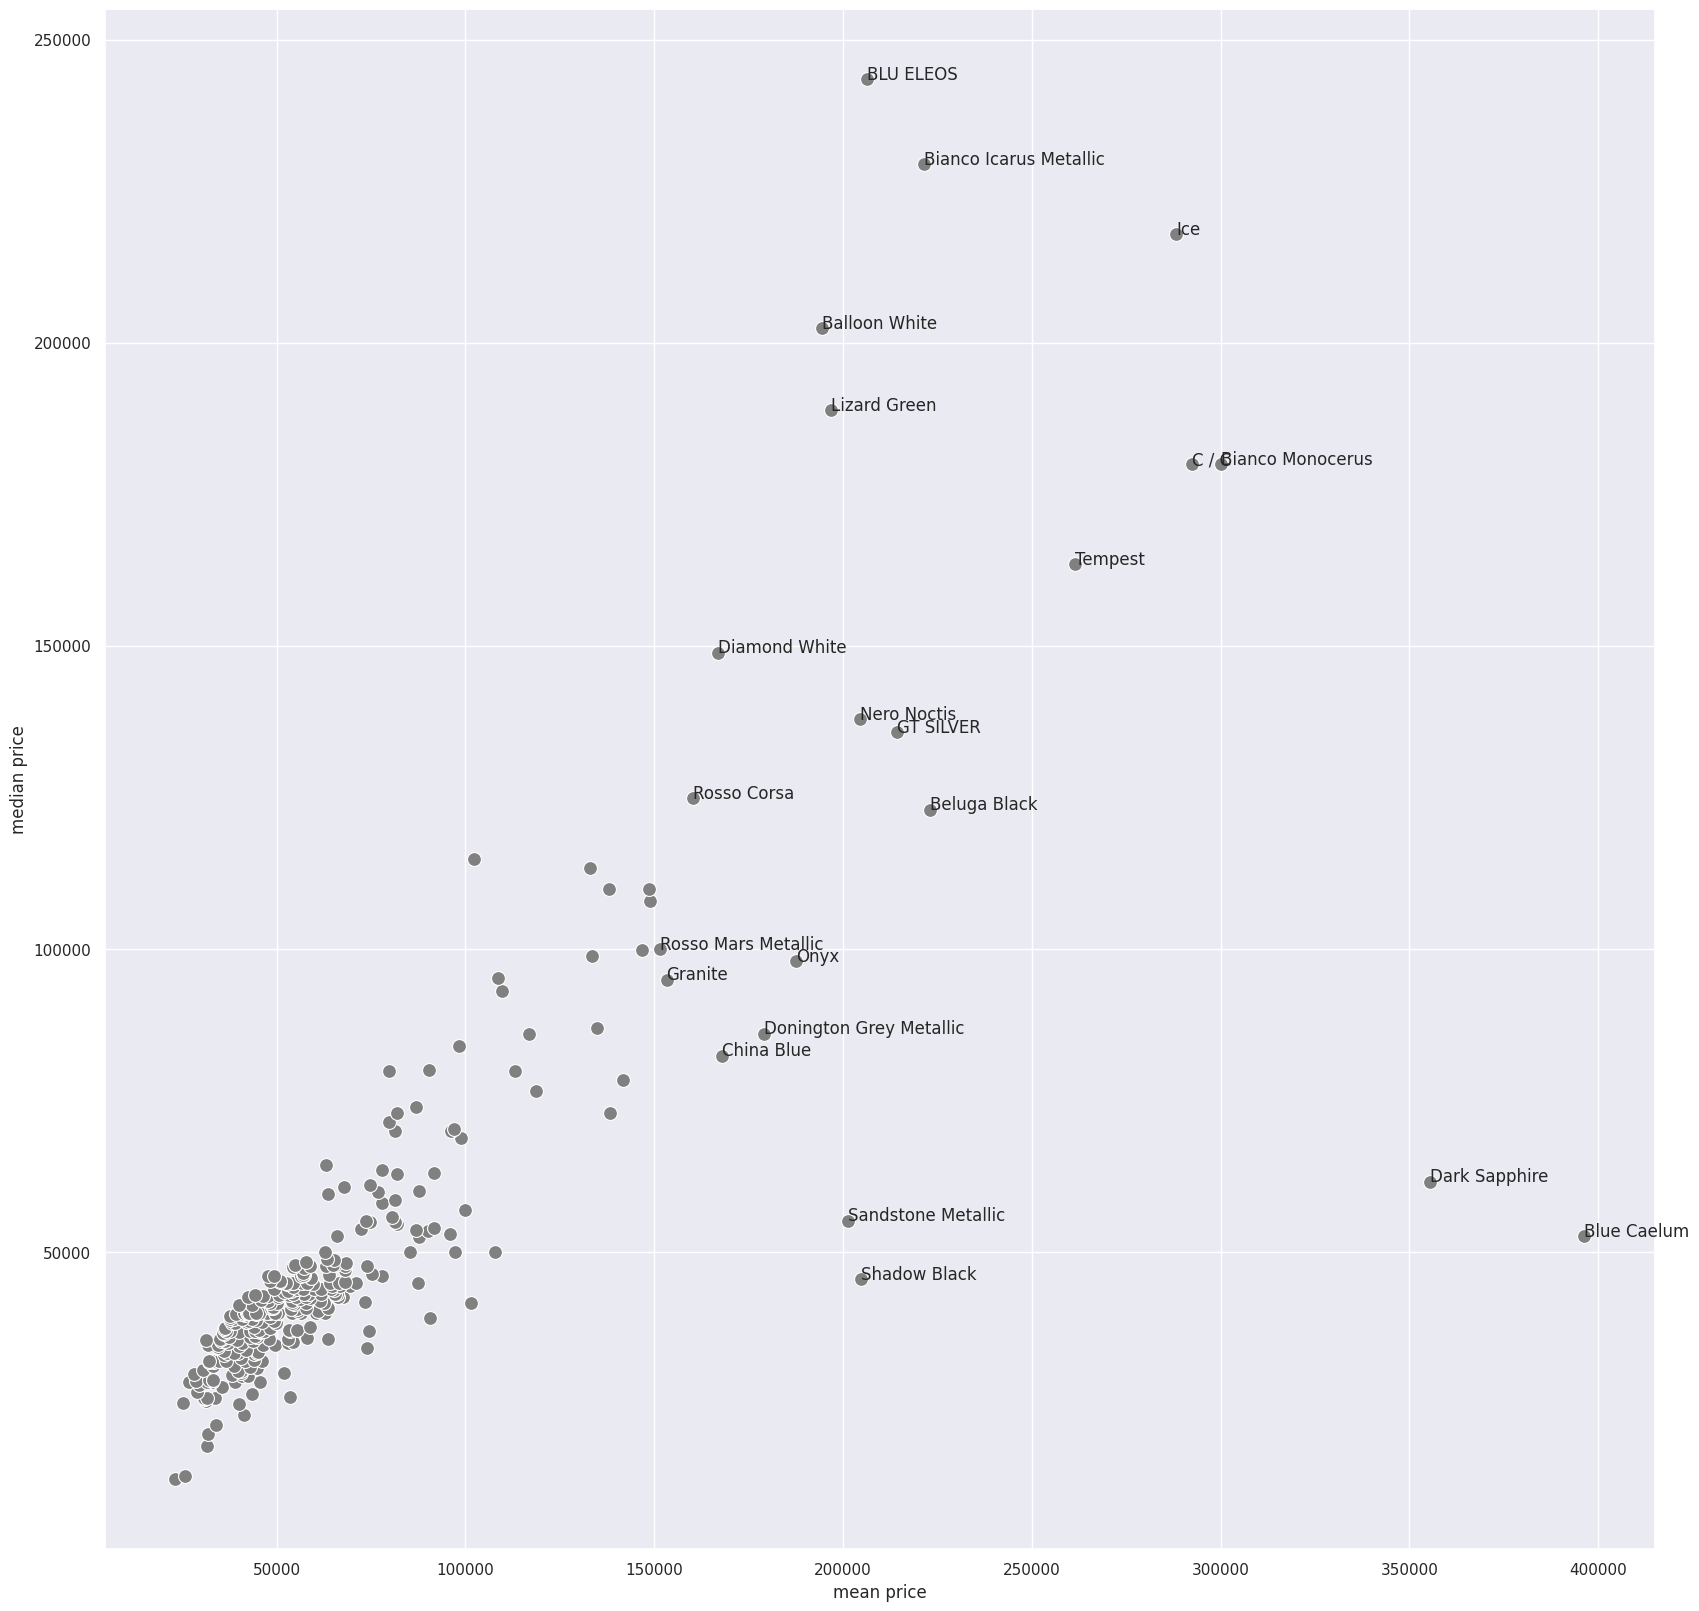

In [ ]:
sns.scatterplot(x=merger['mean price'], y=merger['median price'],
                color='grey', s = 100)


label_point(merger['mean price'], merger['median price'], merger['ext_col'], plt.gca())

plt.show()

In [ ]:
#engine
merger = display_categories(df_train, 'engine')

                                                               engine  median price  mean price  count
                275.0HP 4.2L Straight 6 Cylinder Engine Gasoline Fuel        6099.5      7653.0     12
                        253.0HP 3.5L V6 Cylinder Engine Gasoline Fuel        6450.0     25677.0      5
                         130.0HP 1.8L 4 Cylinder Engine Gasoline Fuel        6500.0      8394.0     59
                        140.0HP 2.8L V6 Cylinder Engine Gasoline Fuel        6500.0      7805.0     43
                         255.0HP 4.8L 8 Cylinder Engine Gasoline Fuel        6700.0     12462.0     16
                        170.0HP 3.3L V6 Cylinder Engine Gasoline Fuel        6900.0      9398.0     17
                         300.0HP 6.0L 8 Cylinder Engine Gasoline Fuel        6950.0      8259.0     27
                         182.0HP 4.0L 8 Cylinder Engine Gasoline Fuel        6999.5      8223.0     34
                         126.0HP 1.8L 4 Cylinder Engine Gasoline Fuel    

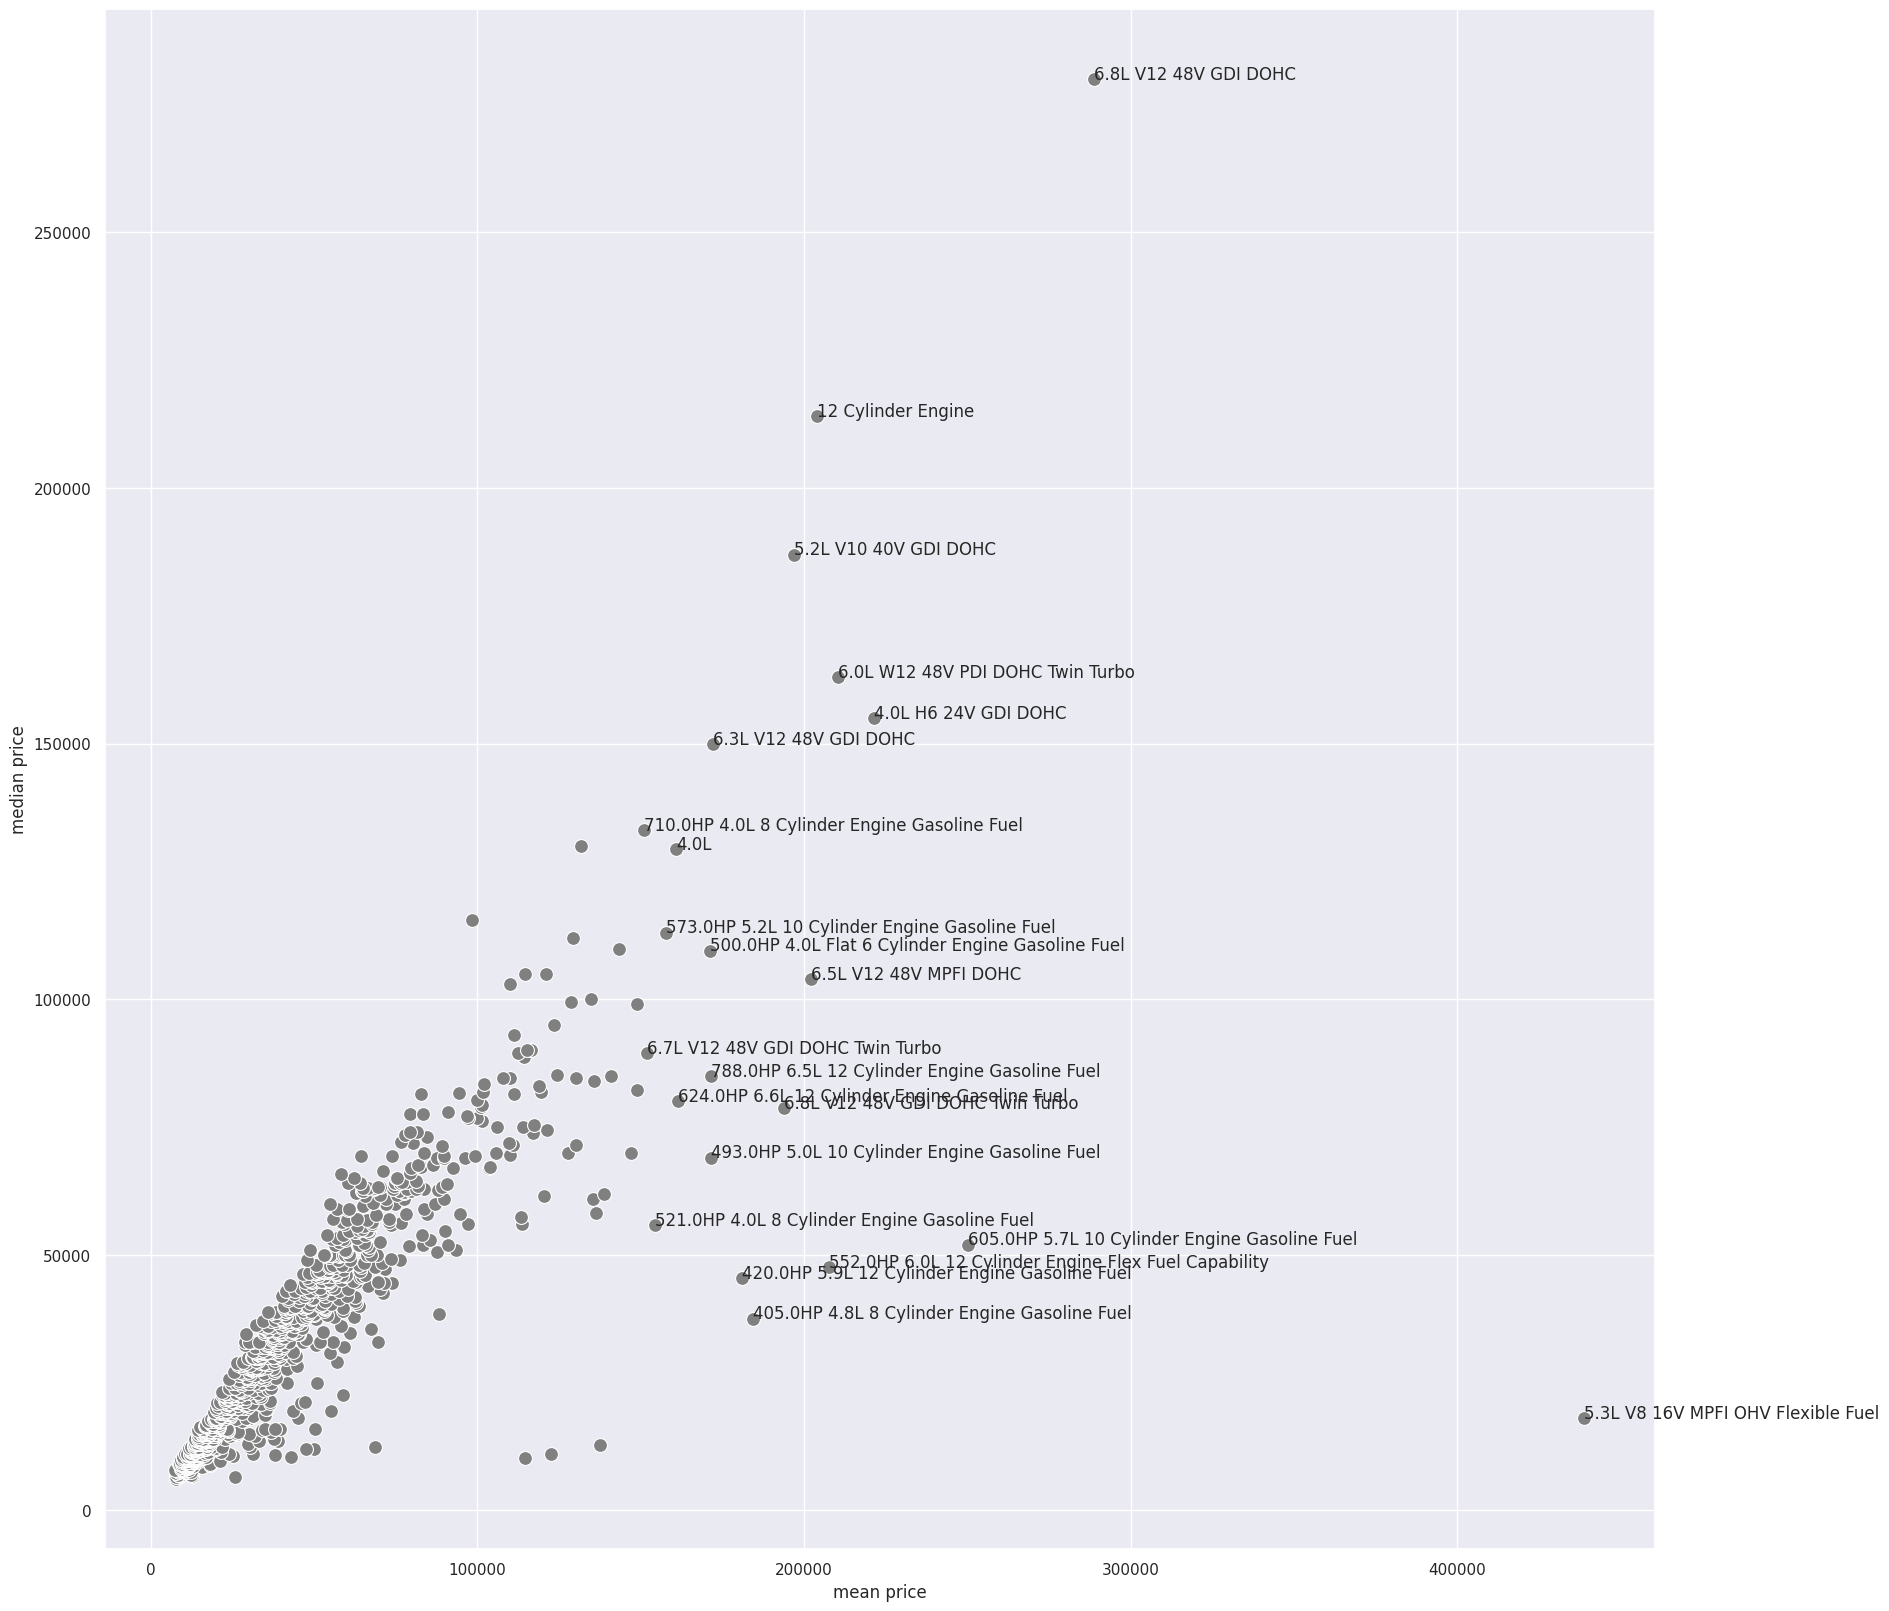

In [ ]:
sns.set(rc={'figure.figsize': (20, 20)})
sns.scatterplot(x=merger['mean price'], y=merger['median price'],
                color='grey', s = 100)

label_point(merger['mean price'], merger['median price'], merger['engine'], plt.gca())

plt.show()

In [ ]:
# #model
merger = display_categories(df_train, 'model')

                                                  model  median price  mean price  count
                                                Yaris L        5750.0      8216.0      8
                                              Matrix XR        6375.0      7688.0     34
                                             Integra LS        6550.0      7683.0     34
                                                 325 xi        6825.0      9925.0     26
                                             Eurovan MV        6875.0      8246.0     42
                                  F-250 XL SuperCab H/D        7047.5     45027.0     16
                              Dakota Big Horn/Lone Star        7100.0      8801.0     40
                                         Cherokee Sport        7350.0     12893.0     22
                                           Dakota Sport        7500.0      9465.0     81
                                           Ram Van 1500        7500.0      8694.0     22
                     

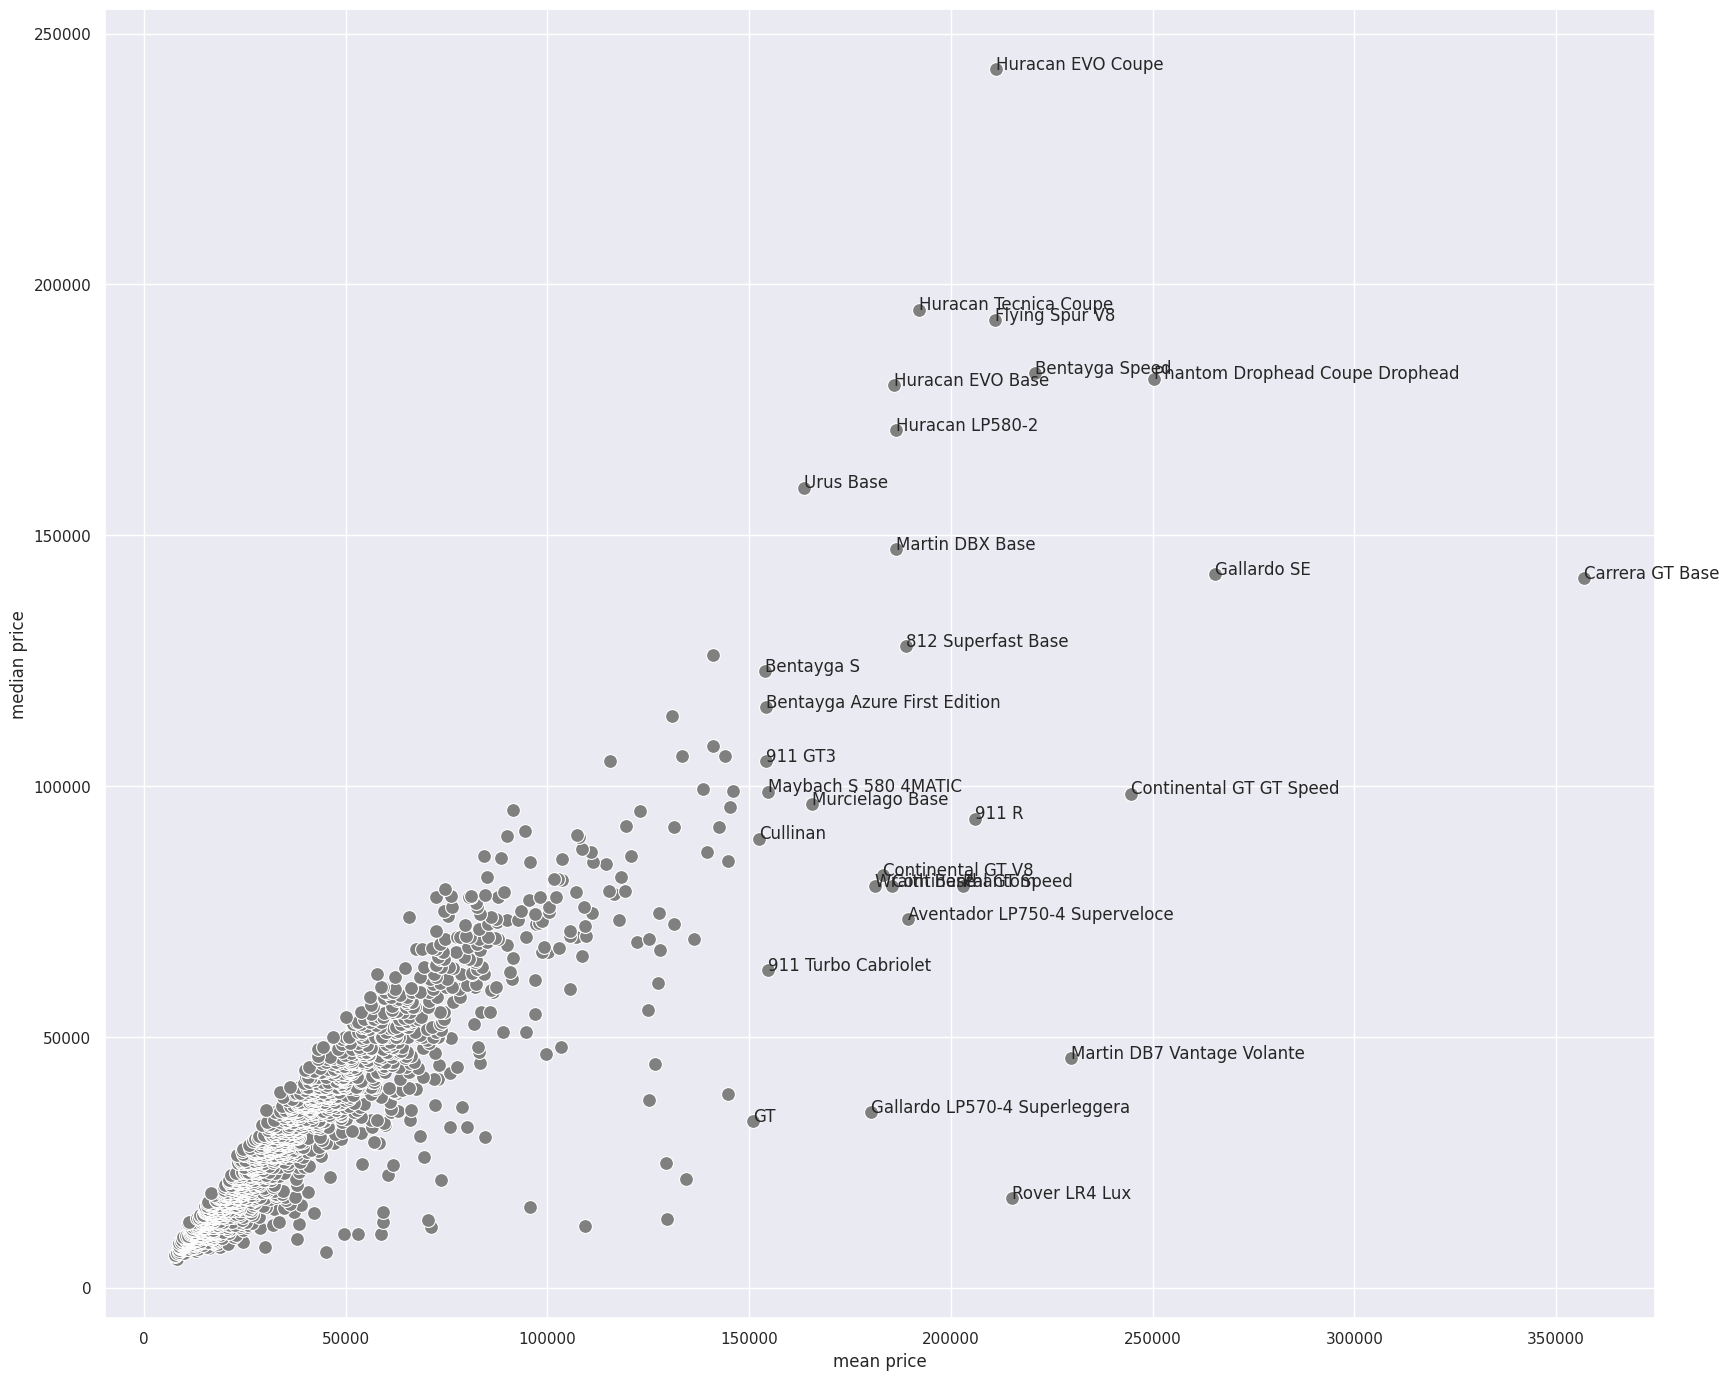

In [ ]:
sns.set(rc={'figure.figsize': (20, 17)})
sns.scatterplot(x=merger['mean price'], y=merger['median price'],
                color='grey', s = 100)

label_point(merger['mean price'], merger['median price'], merger['model'], plt.gca())

plt.show()

### Numerical Columns

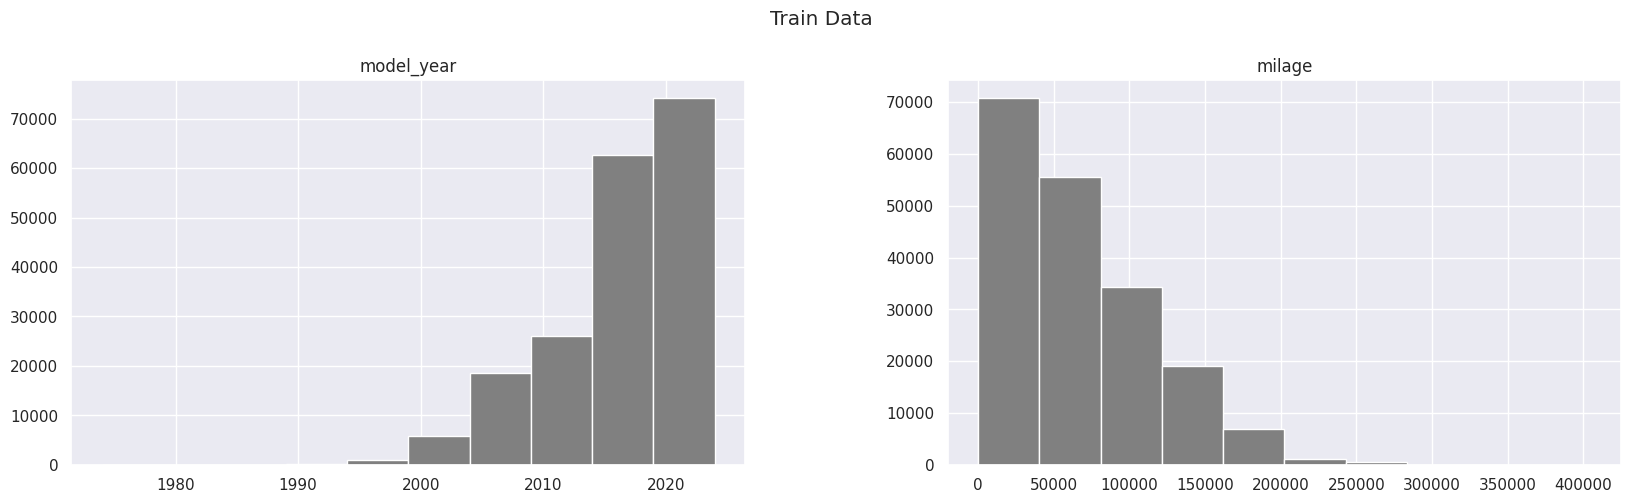

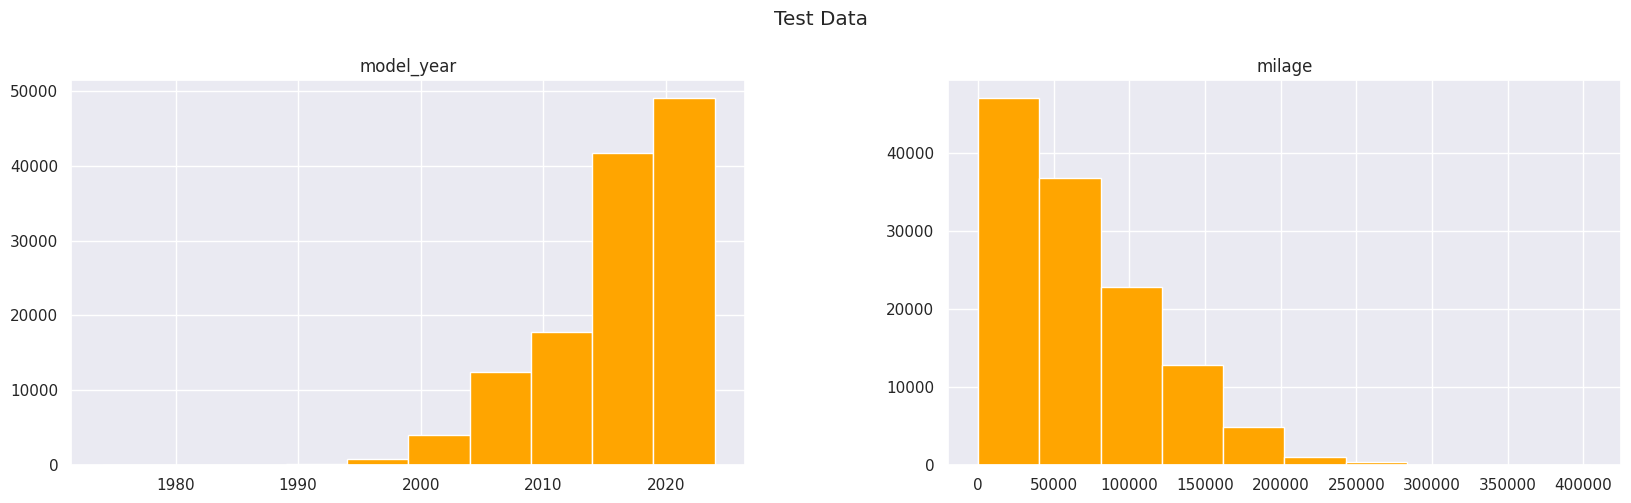

In [ ]:
sns.set(rc={'figure.figsize': (20, 5)})
df_train[num_cols].hist(color = "grey")
plt.suptitle('Train Data', y=1.02)
df_test[num_cols].hist(color = "orange")
plt.suptitle('Test Data', y=1.02)
plt.show()

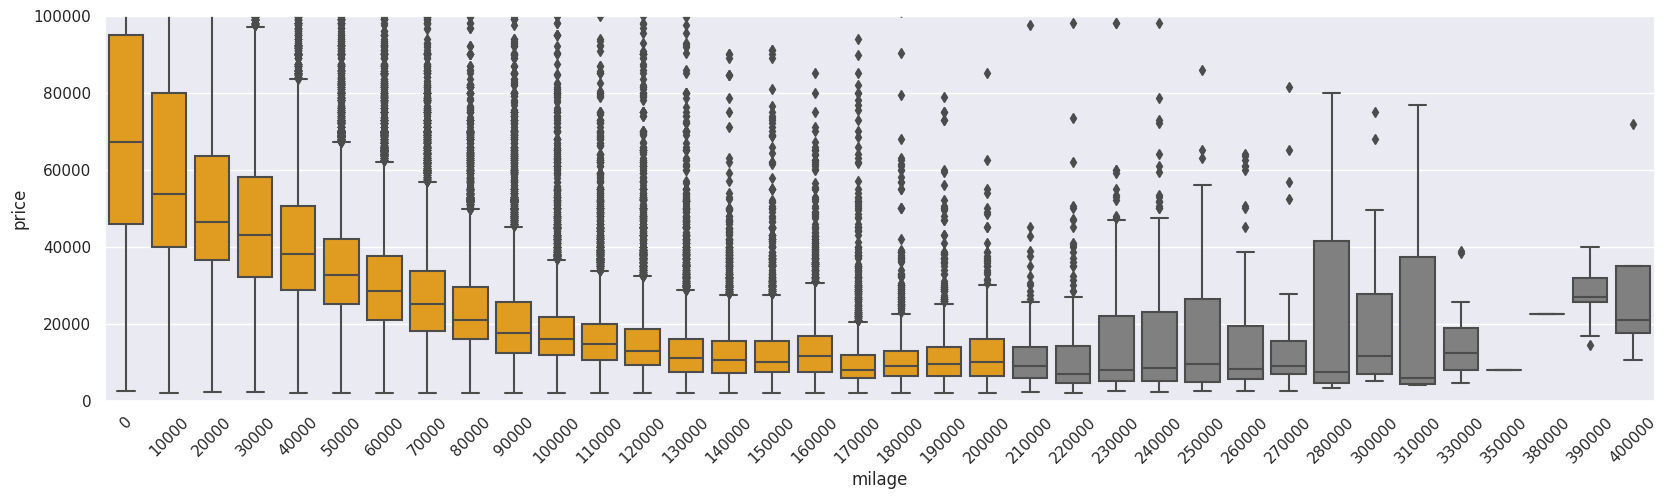

In [ ]:
#Milleage
def set_boxplot_color(x):
    colors = []
    for bin in x.value_counts().index:
        count = x.value_counts()[bin]
        color = 'orange' if count > 500 else 'grey'
        colors.append(color)
    return colors

sns.set(rc={'figure.figsize': (20, 5)})
milage2 = (df_train.milage//10_000)*10_000
colors = set_boxplot_color(milage2)
sns.boxplot(x=milage2, y=df_train['price'], palette = colors)
plt.ylim((0,100_000))
plt.xticks(rotation=45)
plt.show()

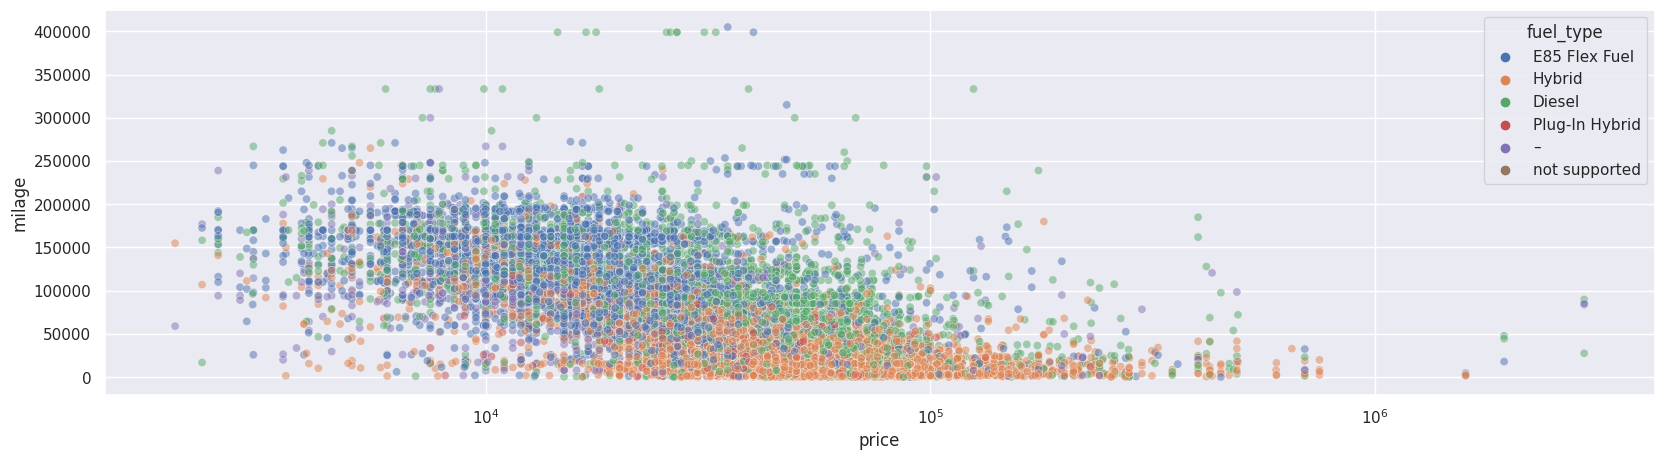

In [ ]:
sns.scatterplot(x=df_train[df_train['fuel_type'] != 'Gasoline']['price'],
                y=df_train[df_train['fuel_type'] != 'Gasoline']['milage'],
                hue = df_train[df_train['fuel_type'] != 'Gasoline']['fuel_type'],
                color='grey', alpha=0.5)
plt.xscale('log')

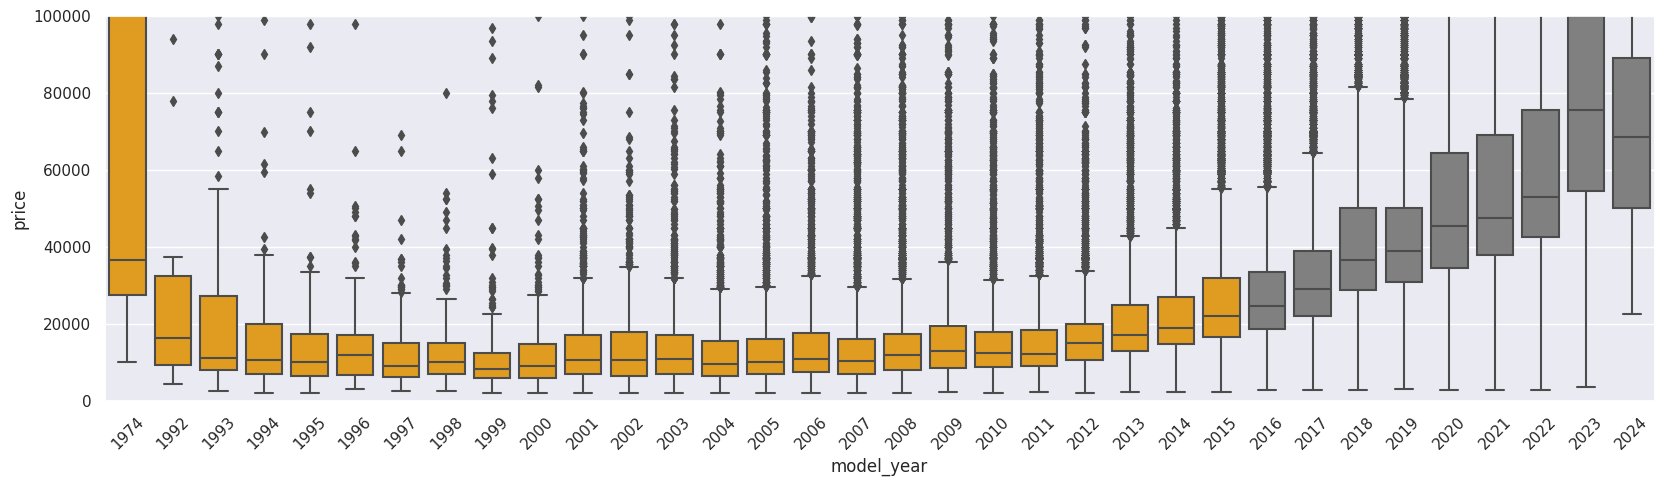

In [ ]:
#model year
#sns.scatterplot(x=df_train['price'], y=df_train['model_year'],
#                color='grey', alpha=0.5, s = 3)
#plt.xscale('log')

colors = set_boxplot_color(df_train['model_year'])
sns.set(rc={'figure.figsize': (20, 5)})
sns.boxplot(x=df_train['model_year'], y=df_train['price'], palette = colors)
plt.ylim((0,100_000))
plt.xticks(rotation=45)
plt.show()

# FEATURE ENGINEERING FOR THE MODEL

In [ ]:
def feat_eng(data):
    #categorical features
    cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
                'int_col', 'accident']
    df = data.copy()
    for feature in ['fuel_type', 'accident', 'clean_title']:
        df[feature] = df[feature].fillna("no_entry")
    df['clean_title'] = np.where(df['clean_title']== 'Yes',1,0).astype('int16')
    df['fuel_type'] = df['fuel_type'].replace({'–':'not supported'})
    df['mileage'] = df['milage']//100
    for feature in cat_cols:
        df[feature] = df[feature].astype('category')
    #numerical features
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype('float').fillna(-1)
    df['displacement'] = df['engine'].str.extract(r'(\d+(\.\d+)?)L')[0].astype(float).fillna(-1)
    return df

In [ ]:
feat_cols = df_test.columns.to_list()
data_concat = feat_eng(pd.concat([df_train[feat_cols], df_original[feat_cols], df_test]))
data_train = data_concat[:len(df_train)]
data_train['price']=df_train['price']
data_original = data_concat[len(df_train):len(df_train)+len(df_original)]
data_original['price'] = df_original['price']
data_test = data_concat[len(df_train)+len(df_original):]
cat_cols = ['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
                'int_col', 'accident', 'model_year','mileage',
           ]
num_cols = ['milage', 'horsepower', 'displacement']

# MODEL BUILDING

## Cross Validation

In [ ]:
def crossvalidate(label, data, test_data, n_bags = 5, n_splits = 5):

        start_time = datetime.datetime.now()
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

        # Initialize lists to store models and cv scores
        scores = []
        weights = []
        shap_values = 0
        feat_scores = 0
        test_pred = np.zeros(len(test_data))
        oof = np.zeros(len(data))
        X_test = test_data
        y = data['price'].astype(float)

        # Perform cross-validation
        for fold, (train_index, valid_index) in enumerate(cv.split(data, y.astype(str))):

            # Split the data into training and validation sets for the current fold
            X_train, X_valid = data.iloc[train_index], data.drop(columns = "price").iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            if label == "CAT":
                X_train = pd.concat([X_train, data_original2,data_original2], axis=0)
                y_train = pd.concat([y_train,data_original2['price'],data_original2['price'],
                                ]
                                ,axis = 0)
                X_train, X_valid, X_test_temp = target_encoding(X_train,X_valid, X_test, cat_cols)
            if label == "LGBM":
                X_train = pd.concat([X_train, data_original,data_original], axis=0)
                y_train = pd.concat([y_train,data_original['price'],data_original['price'],
                                ]
                                ,axis = 0)

            X_train = X_train.drop(columns = ['price'])

            if label != "CAT":
                X_test_temp = X_test

            #to get variation in bags we shuffle columns and change seeds
            for i in range(n_bags):

                cols_temp = X_train.columns.to_list()
                random.Random(i).shuffle(cols_temp)
                X_train = X_train[cols_temp]
                X_test_temp = X_test_temp[cols_temp]
                X_valid = X_valid[cols_temp]

                # Train the model

                if label == "CAT":
                    m = clone(model)
                    m.set_params(random_state=i+seed)
                    m.fit(X_train, y_train,eval_set=[(X_valid, y_valid)])
                elif label == "SVR":
                    m = clone(model)
                    m.named_steps['linearsvr'].random_state = i + seed
                    m.fit(X_train, y_train)
                elif label == "RF":
                    m = clone(model)
                    m.set_params(randomforestregressor__random_state=i + seed)  # correct step name
                    m.fit(X_train, y_train)
                elif label == "ADA":
                    m = clone(model)
                    m.set_params(adaboostregressor__random_state=i + seed)  # use step name
                    m.fit(X_train, y_train)
                elif label == "CAT_2":
                    m = clone(model[label])
                    m.set_params(catboostregressor__random_state=i+seed)
                    m.fit(X_train, y_train, catboostregressor__eval_set=[(X_valid, y_valid)],
                catboostregressor__verbose=0
            )

                    # m.set_params(catboostregressor__random_state=i+seed)
                    # m.fit( X_train, y_train,
                    #       **{f"{last_step_name}__eval_set": [(X_valid, y_valid)]})

                elif label == "LGBM":
                    m = clone(model)
                    m.set_params(catboostregressor__random_state=i+seed)
                    m.fit(X_train, y_train,eval_set=[(X_valid, y_valid)])
                elif label == "NN":
                    X_train_cats = X_train[cat_cols].values
                    X_train_nums = X_train[num_cols].values

                    X_valid_cats = X_valid[cat_cols].values
                    X_valid_nums = X_valid[num_cols].values

                    X_test_cats = X_test_temp[cat_cols].values
                    X_test_nums = X_test_temp[num_cols].values
                    K.clear_session()
                    m = build_model(X_train)
                    m.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss="mean_squared_error",
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])

                    m.fit([X_train_cats,X_train_nums], y_train,
                      validation_data = ([X_valid_cats,X_valid_nums], y_valid),
                      callbacks = [lr_callback],
                      batch_size=64, epochs=EPOCHS, verbose=2)
                else:
                    m = clone(model)
                    m.set_params(random_state=i+seed)
                    m.fit(X_train, y_train)
                    weights.append(m.coef_)
                if label == "NN":
                    y_pred=m.predict([X_valid_cats,X_valid_nums], verbose=1, batch_size=512).flatten()
                    pred = m.predict([X_test_cats,X_test_nums], verbose=1, batch_size=512).flatten()
                elif label == "CAT":
                    y_pred = m.predict_proba(X_valid)[:,1]
                    pred = m.predict_proba(X_test_temp)[:,1]
                else:
                    y_pred = m.predict(X_valid)
                    pred = m.predict(X_test_temp)
                oof[valid_index] += y_pred/n_bags
                test_pred += pred/cv.get_n_splits()/n_bags
            if label == "CAT":
                score = roc_auc_score(y_valid, oof[valid_index])
            else:
                score = np.sqrt(mean_squared_error(y_valid, oof[valid_index]))
            scores.append(score)
            #print(f"Fold {fold} score: {score}")

        elapsed_time = datetime.datetime.now() - start_time
        if label == "CAT":
            print(f"#ROC-AUC score: {np.array(scores)}, mean: {np.array(scores).mean():.7f} (+- {np.array(scores).std():.7f})")
            print(f"#Oof score: {roc_auc_score(y, oof):.7f} ({int(np.round(elapsed_time.total_seconds() / 60))} min)")
        else:
            print(f"#RMSE: {np.array(scores)}, mean: {np.array(scores).mean():.7f} (+- {np.array(scores).std():.7f})")
            print(f"#Oof score: {np.sqrt(mean_squared_error(y, oof)):.7f} ({int(np.round(elapsed_time.total_seconds() / 60))} min)")
        if label in ['Ridge']:
            return test_pred, oof, scores, weights
        else:
            return test_pred, oof, scores

## CATBOOST AS A CLASSIFIER TO GENERATE A PRICE AS A FEATURE WITH THE PROBILITY NO OUTLIER

In [ ]:
def bin_price(data):
    df = data.copy()
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(df['price'], 25)
    Q3 = np.percentile(df['price'], 75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df['price'] > upper_bound)]
    df['price'] = (df['price'] < upper_bound).astype(int)

    return df

In [ ]:
data_concat = bin_price(pd.concat([data_train, data_original]))
data_train2 = data_concat[:len(data_train)]
data_original2 = data_concat[len(data_train):]

In [ ]:
def target_encoding(X_train, X_test, df_test, cat_cols, new_cols = ['median'], smoothing_param = 0.0001):
    """
    Associates mean, median and standard deviation of prices
    with categories for each categorical feature.
    The parameter smoothing_param is implemented to prevent overfitting on rare categories
    and is tunable.
    The new features are returned as integers
    """
    X_train_target = X_train.copy()
    X_test_target = X_test.copy()
    df_test_target = df_test.copy()

    def add_new_feature(name, feature):
        agg = X_train.groupby(feature)[
            'price'].agg(['count', 'mean','median','std'])
        counts = agg['count']
        if name == 'mean':
            target_value = X_train['price'].mean()
            target_fun = agg['mean']
        elif name == 'median':
            target_value = X_train['price'].median()
            target_fun = agg['median']
        elif name == 'std':
            target_value = X_train['price'].std()
            target_fun = agg['std']
        else:
            print("error: target function not implemented")
        price_per_category = (counts * target_fun + smoothing_param * target_value
                                 ) / (counts + smoothing_param)

        return price_per_category, target_value

    for feature in cat_cols:
        for name in new_cols:
            feature_name = feature + '_' + name + '_price'
            price_per_category, target_value = add_new_feature(name, feature)
            X_train_target[feature_name] = X_train_target[feature].map(price_per_category
                                            ).astype(float).fillna(target_value).astype(int)
            X_test_target[feature_name] = (X_test_target[feature].map(price_per_category)
                                          ).astype(float).fillna(target_value).astype(int)
            df_test_target[feature_name] = (df_test_target[feature].map(price_per_category)
                                           ).astype(float).fillna(target_value).astype(int)
    return X_train_target, X_test_target, df_test_target

## FITTING

In [ ]:
cat_params2 = {
    'early_stopping_rounds':25,
    'use_best_model': True,
    "verbose": False ,
    'cat_features': cat_cols,
    'min_data_in_leaf': 16,
    'learning_rate': 0.03355311405703999,
    'random_strength': 11.663619399375248,
    'l2_leaf_reg': 17.703146378123996,
    'max_depth': 10,
    'subsample': 0.9479174100256215,
    'border_count': 130,
    'bagging_temperature': 24.032067560148384
}

In [ ]:
model = CatBoostClassifier(**cat_params2)
test_pred_cat, oof_cat, score_cat = crossvalidate(
    'CAT', data_train2,data_test, n_bags,n_folds)

#ROC-AUC score: [0.89131138 0.89395657 0.88516549 0.88597688 0.88763165], mean: 0.8888084 (+- 0.0033299)
#Oof score: 0.8887766 (62 min)


## SVR

In [ ]:
svr_params = {'C':1000,
              'epsilon':0.2,
              #'gamma':0.0075,
              'max_iter':5000,
              'tol':0.0005,
              #'kernel':'rbf',
              'random_state':42,
             }

In [ ]:
model = make_pipeline(
    TargetEncoder(cols = ['accident','brand','model_year','fuel_type','model',
                         'engine','transmission','ext_col','int_col','clean_title',
                         'mileage','horsepower',
                         ],
                 smoothing = 10,
                 min_samples_leaf = 2),
    StandardScaler().set_output(transform='pandas'),

    LinearSVR(**svr_params)
    #SVR(**svr_params)
)

test_pred_svr, oof_svr, score_svr = crossvalidate('SVR',
                   data_train[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                               'price']],
                    data_test[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                              ]], n_bags,n_folds)

#RMSE: [74352.0494289  74153.56001482 73965.66609808 74129.06460701
 74075.62192805], mean: 74135.1924154 (+- 126.2455530)
#Oof score: 74135.3002572 (1 min)


# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF

In [ ]:
rf_param = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf':2,
    'max_features':'sqrt',
    'n_jobs':-1,
    #'random_state':42,
}

In [ ]:
model = make_pipeline(
    TargetEncoder(cols = ['accident','brand','model_year','fuel_type','model',
                         'engine','transmission','ext_col','int_col','clean_title',
                         'mileage','horsepower',
                         ],
                 smoothing = 10,
                 min_samples_leaf = 2),
    StandardScaler().set_output(transform='pandas'),
    RF(**rf_param)

)

test_pred_rf, oof_rf, score_rf = crossvalidate('RF',
                   data_train[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                               'price']],
                    data_test[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                              ]], n_bags,n_folds)

#RMSE: [73612.02354389 73728.71159552 73453.25495011 73102.5007787
 73384.85264841], mean: 73456.2687033 (+- 213.8905234)
#Oof score: 73456.5823605 (7 min)


# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor as ADA
from sklearn.tree import DecisionTreeRegressor
ada_param = {
    'base_estimator': LGBMRegressor(max_depth=6),
    'n_estimators':200,
    'learning_rate':0.05,

    'random_state':42
}

In [ ]:
model = make_pipeline(
    TargetEncoder(cols = ['accident','brand','model_year','fuel_type','model',
                         'engine','transmission','ext_col','int_col','clean_title',
                         'mileage','horsepower',
                         ],
                 smoothing = 10,
                 min_samples_leaf = 2),
    StandardScaler().set_output(transform='pandas'),
    ADA(**ada_param)

)

test_pred_ada, oof_ada, score_ada = crossvalidate('ADA',
                   data_train[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                               'price']],
                    data_test[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                              ]], n_bags,n_folds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 13
[LightGBM] [Info] Start training from score 44449.343442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# CatBoost

In [ ]:
model = CatBoostClassifier(**cat_params2)
test_pred_cat, oof_cat, score_cat = crossvalidate(
    'CAT', data_train2,data_test, n_bags,n_folds)

In [ ]:
cat_2_param={
        'verbose' : -1,
        'early_stopping_rounds':25,
        'loss_function':"RMSE",
        'n_estimators': 2000,
        'num_leaves': 426,
        'learning_rate': 0.011353178352988012,
        'subsample': 0.5772552201954328,
        #'colsample_bytree': 0.9164865430101521,
        #'reg_alpha': 1.48699088003429e-06,
        'reg_lambda': 0.41539458543414265,
        'min_data_in_leaf': 73,
        #'feature_fraction': 0.751673655170548,
        #'bagging_fraction': 0.5120415391590843,
       #'bagging_freq': 2,
        #'min_child_weight': 0.017236362383443497,
        #'cat_smooth': 54.81317407769262,
        'verbose' : -1
}

In [ ]:
from catboost import CatBoostRegressor as CAT_2


In [ ]:
model = make_pipeline(
    TargetEncoder(cols = ['accident','brand','model_year','fuel_type','model',
                         'engine','transmission','ext_col','int_col','clean_title',
                         'mileage','horsepower',
                         ],
                 smoothing = 10,
                 min_samples_leaf = 2),
    StandardScaler().set_output(transform='pandas'),
    CatBoostRegressor(**cat_2_param)


)

test_pred_cat_2, oof_cat_2, score_cat_2 = crossvalidate('CAT_2',
                   data_train[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                               'price']],
                    data_test[['milage',
                               'model_year','model','brand',
                               'engine','transmission','ext_col','fuel_type',
                               'accident','int_col','clean_title','mileage',
                               #'displacement',
                               'horsepower',
                              ]], n_bags,n_folds)

KeyError: 'CAT_2'

## LGBM

In [ ]:
lgb_params5 = {
    'verbose' : -1,
    'early_stopping_rounds':25,
    'loss_function':"RMSE",
    'n_estimators': 2000,
    'max_bin': 30000,
}
#parameters from https://www.kaggle.com/code/noodl35/best-single-model-lgbm-no-blend
lgb_params1 = {
        'verbose' : -1,
        'early_stopping_rounds':25,
        'loss_function':"RMSE",
        'n_estimators': 2000,
        'num_leaves': 426,
        'learning_rate': 0.011353178352988012,
        'subsample': 0.5772552201954328,
        'colsample_bytree': 0.9164865430101521,
        'reg_alpha': 1.48699088003429e-06,
        'reg_lambda': 0.41539458543414265,
        'min_data_in_leaf': 73,
        'feature_fraction': 0.751673655170548,
        'bagging_fraction': 0.5120415391590843,
        'bagging_freq': 2,
        'min_child_weight': 0.017236362383443497,
        'cat_smooth': 54.81317407769262,
        'verbose' : -1}

In [ ]:
model = LGBMRegressor(**lgb_params1)
test_pred_lgb1, oof_lgb1, score_lgb1 = crossvalidate("LGBM",
                                      data_train,data_test,n_bags,n_folds)

#RMSE: [72652.18091262 72681.84517372 72587.49207511 72369.48188168
 72784.68098103], mean: 72615.1362048 (+- 138.3315383)
#Oof score: 72615.2683671 (5 min)


In [ ]:
data_train2 = data_train.copy()
data_test2 = data_test.copy()

data_train2['price_is_low'] = oof_cat
data_test2['price_is_low'] = test_pred_cat
data_original['price_is_low'] = -1

In [ ]:
model = LGBMRegressor(**lgb_params1)
test_pred_lgb1_st, oof_lgb1_st, score_lgb1_st = crossvalidate("LGBM",
                                      data_train2,data_test2,n_bags,n_folds)

#RMSE: [72580.80038105 72530.01576326 72472.50385441 72293.94761921
 72655.69144   ], mean: 72506.5918116 (+- 122.2013370)
#Oof score: 72506.6951252 (4 min)


In [ ]:
def label_encoding(data, threshold):
    train = data.copy()
    le = LabelEncoder()

    # LABEL ENCODE CATEGORICAL FEATURES
    CAT_SIZE = []
    CAT_EMB = []
    RARE = []

    print("LABEL ENCODING:")
    for c in cat_cols:
        # LABEL ENCODE
        train[c] = le.fit_transform(train[c])
        #train[c],_ = train[c].factorize()
        train[c] -= train[c].min()
        vc = train[c].value_counts()

        # IDENTIFY RARE VALUES
        RARE.append( vc.loc[vc<threshold].index.values ) #40
        n = train[c].nunique()
        mn = train[c].min()
        mx = train[c].max()
        r = len(RARE[-1])
        print(f'{c}: nunique={n}, min={mn}, max={mx}, rare_ct={r}')

        # RELABEL RARE VALUES AS ZERO
        CAT_SIZE.append(mx+1 +1) #ADD ONE FOR RARE
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1 +1))) ) # ADD ONE FOR RARE
        train[c] += 1
        train.loc[train[c].isin(RARE[-1]),c] = 0
    return train, CAT_SIZE, CAT_EMB

In [ ]:
data_concat, CAT_SIZE, CAT_EMB = label_encoding(
    pd.concat([data_train2, data_original, data_test2]),5)
data_train2 = data_concat[:len(df_train)]
data_original = data_concat[len(df_train):len(df_train)+len(df_original)]
data_test2 = data_concat[len(df_train)+len(df_original):]

LABEL ENCODING:
brand: nunique=57, min=0, max=56, rare_ct=1
model: nunique=1898, min=0, max=1897, rare_ct=11
fuel_type: nunique=7, min=0, max=6, rare_ct=0
engine: nunique=1146, min=0, max=1145, rare_ct=33
transmission: nunique=62, min=0, max=61, rare_ct=10
ext_col: nunique=319, min=0, max=318, rare_ct=0
int_col: nunique=156, min=0, max=155, rare_ct=0
accident: nunique=3, min=0, max=2, rare_ct=0
model_year: nunique=36, min=0, max=35, rare_ct=2
mileage: nunique=1850, min=0, max=1849, rare_ct=343


In [ ]:
model = LGBMRegressor(**lgb_params5)
test_pred_lgb5_st, oof_lgb5_st, score_lgb5_st = crossvalidate("LGBM",
                                      data_train2,data_test2,n_bags,n_folds)

#RMSE: [72649.59332411 72690.06536968 72377.06754249 72376.58991013
 72869.56454542], mean: 72592.5761384 (+- 191.0872539)
#Oof score: 72592.8273144 (0 min)


# NN

In [ ]:
#Processing
# STANDARIZE NUMERICAL FEATURES
def standardize_all(data):
    train = data.copy()
    print("STANDARDIZING: ",end="")
    for c in num_cols:
        print(c,', ',end='')
        m = train[c].mean()
        s = train[c].std()
        train[c] = (train[c]-m)/s
        train[c] = train[c].fillna(m)
    return train

In [ ]:
feat_cols = data_test.columns.to_list()
data_concat = standardize_all(pd.concat([data_train[feat_cols], data_test]))
data_train2 = data_concat[:len(data_train)]
data_train2['price']=data_train['price']
data_test2 = data_concat[len(data_train):]

STANDARDIZING: milage , horsepower , displacement , 

#### Standardizing milage , horsepower , displacement

In [ ]:
def one_hot_encoding(df_train, df_test, cat_cols, cat_cols_old):

    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])

    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('int32')
    df_train = df_train.drop(columns = cat_cols)

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('int32')
    df_test = df_test.drop(columns = cat_cols)

    for col in cat_cols:
        cat_cols_old.remove(col)

    cat_cols_old.extend(new_cat_cols)
    #cat_cols = new_cat_cols

    return df_train, df_test, cat_cols_old

In [ ]:
cat_cols2 = ['fuel_type','accident']
feat_cols = data_test.columns.to_list()
data_train2, data_test2, cat_cols = one_hot_encoding(data_train2, data_test2, cat_cols2, cat_cols)

In [ ]:
feat_cols = data_test2.columns.to_list()
data_concat, CAT_SIZE, CAT_EMB = label_encoding(pd.concat([data_train2[feat_cols], data_test2]),20)
data_train2 = data_concat[:len(data_train2)]
data_train2['price']=data_train['price']
data_test2 = data_concat[len(data_train2):]


LABEL ENCODING:
brand: nunique=57, min=0, max=56, rare_ct=6
model: nunique=1898, min=0, max=1897, rare_ct=188
engine: nunique=1118, min=0, max=1117, rare_ct=116
transmission: nunique=52, min=0, max=51, rare_ct=2
ext_col: nunique=319, min=0, max=318, rare_ct=33
int_col: nunique=156, min=0, max=155, rare_ct=11
model_year: nunique=36, min=0, max=35, rare_ct=3
mileage: nunique=1850, min=0, max=1849, rare_ct=515
onehot_0: nunique=2, min=0, max=1, rare_ct=0
onehot_1: nunique=2, min=0, max=1, rare_ct=0
onehot_2: nunique=2, min=0, max=1, rare_ct=0
onehot_3: nunique=2, min=0, max=1, rare_ct=0
onehot_4: nunique=2, min=0, max=1, rare_ct=0
onehot_5: nunique=2, min=0, max=1, rare_ct=0
onehot_6: nunique=2, min=0, max=1, rare_ct=0
onehot_7: nunique=2, min=0, max=1, rare_ct=0
onehot_8: nunique=2, min=0, max=1, rare_ct=0
onehot_9: nunique=2, min=0, max=1, rare_ct=0


In [ ]:
def relabel_unseen(data_train,data_test):
    train = data_train.copy()
    test = data_test.copy()
    for c in cat_cols:
        # COMPARE TEST CAT VALUES TO TRAIN CAT VALUES
        A = train[c].unique()
        B = test[c].unique()
        C = np.setdiff1d(B,A)
        print(f"{c}: Test has label encodes = {C} which are not in train.")
        if len(C)>0:
            print(f" => {len(test.loc[test[c].isin(C)])} rows" )

        # RELABEL UNSEEN TEST VALUES AS ZERO
        test.loc[test[c].isin(C),c] = 0
    return test

In [ ]:
data_test2 = relabel_unseen(data_train2, data_test2)

brand: Test has label encodes = [] which are not in train.
model: Test has label encodes = [] which are not in train.
engine: Test has label encodes = [132] which are not in train.
 => 4 rows
transmission: Test has label encodes = [] which are not in train.
ext_col: Test has label encodes = [] which are not in train.
int_col: Test has label encodes = [] which are not in train.
model_year: Test has label encodes = [3] which are not in train.
 => 1 rows
mileage: Test has label encodes = [ 299  327  405  427  742  755  805  820  823  853  890  939  947  989
  992 1055 1073 1085 1095 1120 1132 1134 1153 1158 1169 1198 1226 1238
 1246 1251 1290 1294 1365 1377 1379 1394 1448 1450 1455 1507 1570 1582
 1606 1608 1623 1674 1695 1723 1736 1744 1747 1750 1758 1773 1789 1804
 1839] which are not in train.
 => 87 rows
onehot_0: Test has label encodes = [] which are not in train.
onehot_1: Test has label encodes = [] which are not in train.
onehot_2: Test has label encodes = [] which are not in trai

### Model Architecture

In [ ]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, Multiply
import tensorflow.keras.backend as K

print('TF Version',tf.__version__)

2025-09-13 23:23:22.663657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757805803.078784      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757805803.192388      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF Version 2.18.0


Learning rate schedule: 0.001 to 0.001 to 0.0001


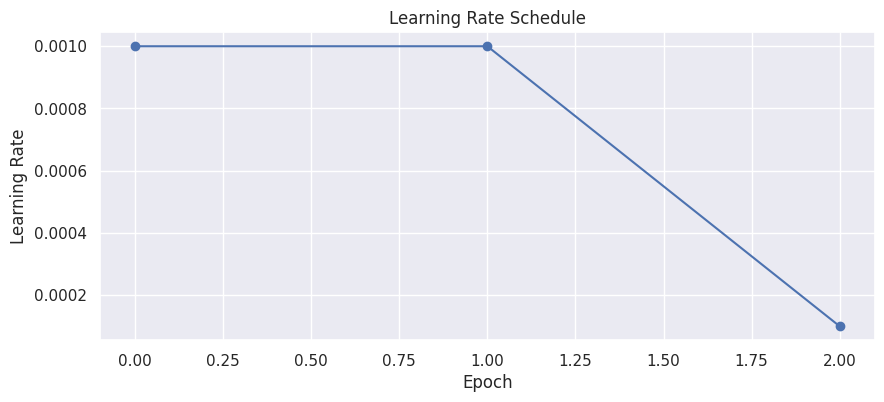

In [ ]:
EPOCHS = 3
LRS = [0.001]*2 + [0.0001]*1 #+ [0.00001]*1

def lrfn(epoch):
    return LRS[epoch]

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
        format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
def build_model(X_train):

    ## CATEGORICAL FEATURES
    x_input_cats = Input(shape=(len(cat_cols),))
    embs = []
    for j in range(len(cat_cols)):
        e = tf.keras.layers.Embedding(CAT_SIZE[j],CAT_EMB[j])
        x = e(x_input_cats[:,j])
        x = tf.keras.layers.Flatten()(x)
        embs.append(x)

    # NUMERICAL FEATURES
    x_input_nums = Input(shape=(len(num_cols),))

    # COMBINE
    concatenated = tf.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums])
    x = Dense(256, activation='gelu')(concatenated)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='linear')(x)

    model = Model(inputs=[x_input_cats,x_input_nums], outputs=x)

    return model

In [ ]:
tf.keras.utils.plot_model(
    model=build_model(data_train2),
    show_shapes=True,
    rankdir='TB')

I0000 00:00:1757805906.035634      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757805906.036423      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
data_train2 = data_train2.drop(columns = ["horsepower","displacement"])
data_test2 = data_test2.drop(columns = ["horsepower","displacement"])
num_cols = ['milage']
test_pred_nn, oof_nn, score_nn = crossvalidate("NN",
                                      data_train2,data_test2,n_bags,n_folds)
#onehot: 72812 - 72796
#labelenc: 72829 - 72822


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/3


I0000 00:00:1757805930.351073     352 service.cc:148] XLA service 0x78d738004ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757805930.352721     352 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757805930.352743     352 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757805931.013860     352 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757805933.154269     352 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2357/2357 - 21s - 9ms/step - loss: 5472604672.0000 - root_mean_squared_error: 73977.0547 - val_loss: 5335567360.0000 - val_root_mean_squared_error: 73044.9688 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/3
2357/2357 - 7s - 3ms/step - loss: 5237593600.0000 - root_mean_squared_error: 72371.2188 - val_loss: 5319856640.0000 - val_root_mean_squared_error: 72937.3438 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/3
2357/2357 - 7s - 3ms/step - loss: 5131843072.0000 - root_mean_squared_error: 71636.8828 - val_loss: 5321427456.0000 - val_root_mean_squared_error: 72948.1094 - learning_rate: 1.0000e-04
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/3
2357/2357 - 19s - 8ms/step - loss: 5471989248.0000 - root_mean_squared_error: 73972.8906 - val_loss: 5335195648.0000 - val_root_mean_squared_erro

In [ ]:
# SAVE OOF
oof_df["pred_svr"] = oof_svr
oof_df["pred_lgb1"] = oof_lgb1
oof_df["pred_lgb1_st"] = oof_lgb1_st
oof_df["pred_lgb5_st"] = oof_lgb5_st
oof_df["pred_nn"] = oof_nn
oof_df.to_csv(f"oof_v{VER}.csv",index=False)

# SAVE test predictions
test_df["pred_svr"] = test_pred_svr
test_df["pred_lgb1"] = test_pred_lgb1
test_df["pred_lgb1_st"] = test_pred_lgb1_st
test_df["pred_lgb5_st"] = test_pred_lgb5_st
test_df["pred_nn"] = test_pred_nn
test_df.to_csv(f"test_v{VER}.csv",index=False)

In [ ]:
oof_df.head()

id      pred_svr     pred_lgb1  pred_lgb1_st  pred_lgb5_st       pred_nn
0   0   6176.422695   9436.816139  10088.655219   9677.672042  12325.470703
1   1   8356.239171  10495.279871  10567.012946  10874.646196  11063.219727
2   2  12439.143189  13811.980111  13056.195199  17169.255046  15967.398926
3   3  49218.220960  59133.594410  61887.668602  72552.810700  69019.830078
4   4  58817.900231  84175.221905  84524.187618  71827.013221  99458.537109

In [ ]:
test_df.head()

In [ ]:
oof_df = oof_df.drop(columns = "id")
oof_df["price"] = df_train["price"]
test_df = test_df.drop(columns = "id")

In [ ]:
ridge_params = {"alpha":1.0,
               "fit_intercept":False,
               "max_iter":200,
               "tol":0.0001,
               "solver":'lbfgs',
               "positive":True,
               "random_state":seed}
model = Ridge(**ridge_params)
test_pred_ensemble, oof_ensemble, score_ensemble, weights_ensemble = crossvalidate(
    'Ridge', oof_df,test_df, 1,n_folds)

#RMSE: [72459.53892357 72465.63598574 72290.98282874 72155.13223602
 72608.02131439], mean: 72395.8622577 (+- 156.7706568)
#Oof score: 72396.0321477 (0 min)


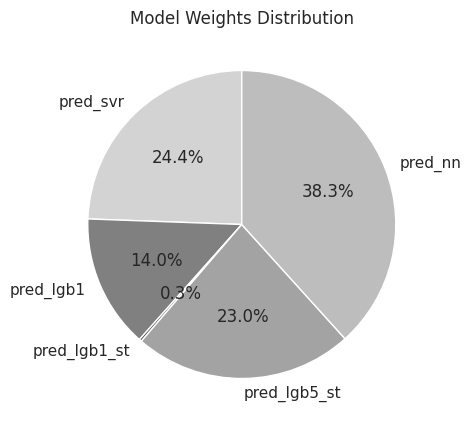

In [ ]:
mean_weights = np.mean(np.stack(weights_ensemble), axis=0)

# Define the names (columns)
model_names = test_df.columns.to_list()

# Plot the pie chart
plt.figure(figsize=(5, 5))
plt.pie(mean_weights, labels=model_names, autopct='%1.1f%%', startangle=90,
       colors = ["#d3d3d3","grey",'#545454','#a3a3a3','#bdbdbd'])
plt.title('Model Weights Distribution')
plt.show()

# EVALUATION

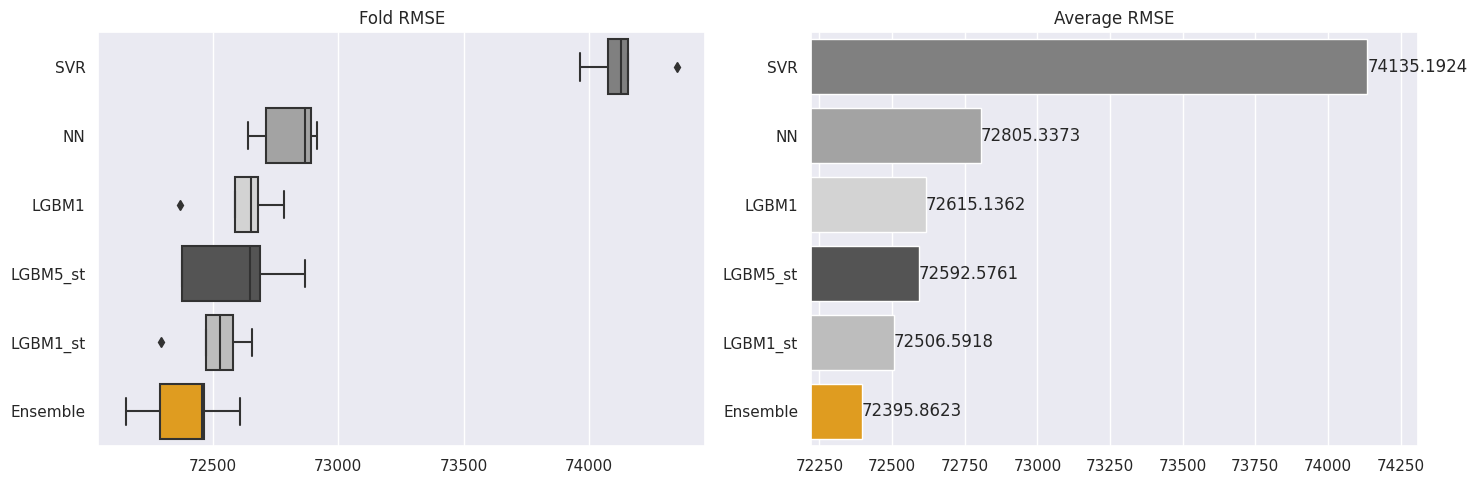

In [ ]:
scores = {}
scores['SVR'] = score_svr
scores['LGBM1'] = score_lgb1
scores['LGBM1_st'] = score_lgb1_st
scores['LGBM5_st'] = score_lgb5_st
scores["NN"] = score_nn
scores['Ensemble'] = score_ensemble
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.1
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette=["grey",'#a3a3a3', "#d3d3d3",
                                                                      '#545454', '#bdbdbd',"orange"])
axs[0].set_title('Fold RMSE')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1],
                      palette = ["grey", '#a3a3a3',"#d3d3d3",'#545454', '#bdbdbd',"orange"])
axs[1].set_title('Average RMSE')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

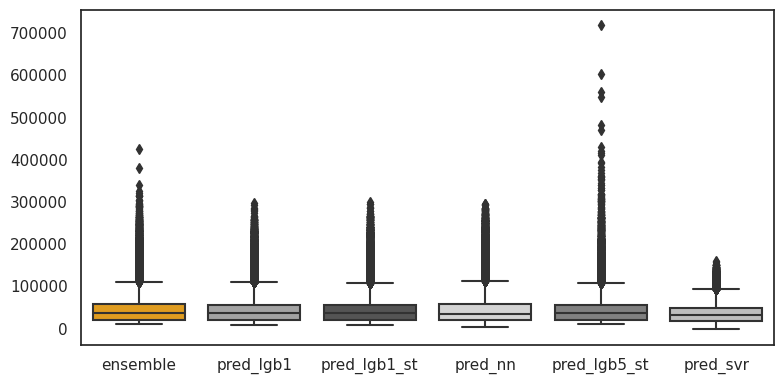

In [ ]:
sns.set(rc={'figure.figsize': (8, 4)})
sns.set_style("white")
test_df["ensemble"] = test_pred_ensemble
order = test_df.mean().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(data = test_df,order=order, palette=["orange",'#a3a3a3','#545454',"#d3d3d3","grey", '#bdbdbd'])
#plt.yscale('log')
plt.tight_layout()

# SUMISSION

### Postpreocessing

In [ ]:
test_pred_ensemble = np.clip(test_pred_ensemble, 2000, 2954083)

## submission

In [ ]:
sample_sub['price'] = test_pred_ensemble
sample_sub.to_csv("submission_multiple_models.csv",index=None)
sample_sub.head()

id         price
0  188533  20058.373989
1  188534  77093.127275
2  188535  59382.012623
3  188536  32284.957603
4  188537  29724.116342

In [ ]:
train.head()

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [ ]:
test.head()

id brand                 model  model_year  milage fuel_type  \
0  188533  Land        Rover LR2 Base        2015   98000  Gasoline   
1  188534  Land     Rover Defender SE        2020    9142    Hybrid   
2  188535  Ford    Expedition Limited        2022   28121  Gasoline   
3  188536  Audi         A6 2.0T Sport        2016   61258  Gasoline   
4  188537  Audi  A6 2.0T Premium Plus        2018   59000  Gasoline   

                                              engine        transmission  \
0       240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel         6-Speed A/T   
1  395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...         8-Speed A/T   
2                    3.5L V6 24V PDI DOHC Twin Turbo  10-Speed Automatic   
3                                     2.0 Liter TFSI           Automatic   
4       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                 A/T   

           ext_col int_col       accident clean_title  
0            White   Beige  None reported         Yes  
1           Silver   Black  None reported         Yes  
2            White   Ebony  None reported         NaN  
3  Silician Yellow   Black  None reported         NaN  
4             Gray   Black  None reported         Yes

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [ ]:
train['model_year'].value_counts()

model_year
2021    18198
2018    16414
2020    15848
2022    15749
2019    15409
2016    13696
2017    12794
2015    11389
2023     8769
2014     8415
2013     6796
2011     6265
2012     6095
2008     5156
2007     4876
2010     4235
2005     3129
2006     2814
2009     2716
2004     2570
2003     1906
2001     1534
2002     1282
2000      558
1999      554
1998      343
1997      312
1996      189
2024      162
1993      140
1995      102
1994       92
1992       14
1974       12
Name: count, dtype: int64

In [ ]:
train['model'].value_counts()

model
F-150 XLT                        2945
M3 Base                          2229
Camaro 2SS                       1709
M4 Base                          1622
Mustang GT Premium               1526
                                 ... 
IONIQ Plug-In Hybrid SEL            2
X5 3.0i                             1
X5 xDrive40e                        1
XLR Base                            1
Integra w/A-Spec Tech Package       1
Name: count, Length: 1897, dtype: int64

In [ ]:
orig.head()

brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                                             engine  \
0  E85 Flex Fuel  300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...   
1       Gasoline                               3.8L V6 24V GDI DOHC   
2       Gasoline                                     3.5 Liter DOHC   
3         Hybrid  354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...   
4       Gasoline                         2.0L I4 16V GDI DOHC Turbo   

        transmission                 ext_col int_col  \
0        6-Speed A/T                   Black   Black   
1  8-Speed Automatic         Moonlight Cloud    Gray   
2          Automatic                    Blue   Black   
3        7-Speed A/T                   Black   Black   
4  8-Speed Automatic  Glacier White Metallic   Black   

                                 accident clean_title    price  
0  At least 1 accident or damage reported         Yes  $10,300  
1  At least 1 accident or damage reported         Yes  $38,005  
2                           None reported         NaN  $54,598  
3                           None reported         Yes  $15,500  
4                           None reported         NaN  $34,999